# Predict #
To be re-inserted into main Jupyter Notebook after.

In [1]:
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

# For neural networks.
import keras as kr
# For data frames.
import pandas as pd
# For numerical arrays.
import numpy as np
# For preprocessing data.
import sklearn.preprocessing as pre
# For splitting data sets.
import sklearn.model_selection as mod
# For whitening.
import sklearn.decomposition as dec
# to write to csv file
import csv

Using TensorFlow backend.


In [2]:
# Import sklearn for comparison too
from sklearn.datasets import load_boston
from sklearn.model_selection import train_test_split

In [3]:
# Load the dataset into a dataframe
data = pd.DataFrame(data = load_boston().data, columns= load_boston().feature_names)
# Add the house price
data["MEDV"] = load_boston().target
# Quick check that all is ok
data.head()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,MEDV
0,0.00632,18.0,2.31,0.0,0.538,6.575,65.2,4.0900,1.0,296.0,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0.0,0.469,6.421,78.9,4.9671,2.0,242.0,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0.0,0.469,7.185,61.1,4.9671,2.0,242.0,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0.0,0.458,6.998,45.8,6.0622,3.0,222.0,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0.0,0.458,7.147,54.2,6.0622,3.0,222.0,18.7,396.90,5.33,36.2


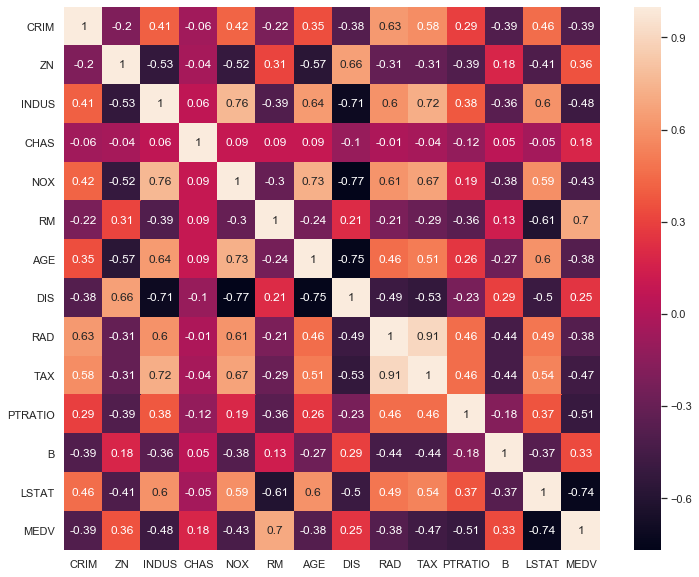

In [4]:
sns.set(rc={'figure.figsize':(12,10)})
correlation_matrix = data.corr().round(2)
# annot = True to print the values inside the square
sns.heatmap(data=correlation_matrix, annot=True)

In [5]:
correlation_matrix["MEDV"]

CRIM      -0.39
ZN         0.36
INDUS     -0.48
CHAS       0.18
NOX       -0.43
RM         0.70
AGE       -0.38
DIS        0.25
RAD       -0.38
TAX       -0.47
PTRATIO   -0.51
B          0.33
LSTAT     -0.74
MEDV       1.00
Name: MEDV, dtype: float64

In [6]:
cm = correlation_matrix.transform(func= lambda x: abs(x))["MEDV"].sort_values(ascending=False)
cm = cm.drop("MEDV",axis=0)
cm

LSTAT      0.74
RM         0.70
PTRATIO    0.51
INDUS      0.48
TAX        0.47
NOX        0.43
CRIM       0.39
RAD        0.38
AGE        0.38
ZN         0.36
B          0.33
DIS        0.25
CHAS       0.18
Name: MEDV, dtype: float64

Because the TAX and RAD parameters are highly correlated (0.91) both should not be  used in training any model. As TAX has a higher correlation than RAD, the RAD feature will be dropped.

In [7]:
cm = cm.drop("RAD",axis=0)
cm

LSTAT      0.74
RM         0.70
PTRATIO    0.51
INDUS      0.48
TAX        0.47
NOX        0.43
CRIM       0.39
AGE        0.38
ZN         0.36
B          0.33
DIS        0.25
CHAS       0.18
Name: MEDV, dtype: float64

In [8]:
# Putting all possible parameters in a list in order of correlation
params = []
for i in range(0, len(cm)):
    params.append(cm.index[i])

In [9]:
y = data['MEDV'] # outputs

def getInputs(noPar):
    # Split the dataset into what we are using
    return data[params[:noPar]] # inputs

In [10]:
def scaleDS(inputs):
    # Adding a scaler
    scaler = pre.StandardScaler()
    scaler.fit(inputs)
    return scaler.transform(inputs)

In [11]:
def splitDS(inputs):
    global x_train, x_test, y_train, y_test
    # Split the dataset into training and testing
    x_train, x_test, y_train, y_test = mod.train_test_split(inputs, y, test_size=testSize)

In [12]:
def createModel(actType, optType):
    global noParams, noEpoch, batchSize
    # Create our model
    m = kr.models.Sequential()
    m.add(kr.layers.Dense(20, input_dim=noParams, activation = actType))
    m.add(kr.layers.Dense(1, activation="linear"))
    m.compile(loss = "mean_squared_error", optimizer =optType)
    # Train the network
    m.fit(x_train, y_train, epochs=noEpoch, batch_size=batchSize)
    return m

In [13]:
def doModel(model, epo, bs):
    global x_trian, x_test, y_tran, y_test, batchSize
    # Train the network
    model.fit(x_train, y_train, epochs=epo, batch_size=bs)
    # Calculate the loss function (Mean squared error in our case)
    return model.evaluate(x_test, y_test)

In [14]:
# Headings for the data
results= []

In [105]:
# Parameterise everything

# Do you want to create and test all the models? 
# If yes, set the following to true, if no, leave at false and data from previous run will be read into dataframe
yesCreateModels = True

# No of variables to include in predictions
noParams = 4 

# Test / Train Split
testSize = 0.3

# All the activations
acts = ["relu", "tanh", "sigmoid", "exponential", "elu", "linear"]
#act = acts[5]


# model trial settings
# Optimisers
opts= ["sgd", "adam", "nadam"]
opt = opts[2]
noEpoch= 100
batchSize = 10

# Whether the data should be scaled or not
scaling = True

if yesCreateModels == True:
    results= []
    # Check for increasing no of attributes and all activations
    for act in acts:
        for noParams in range(1,12):
            print("Starting", act, "Parameter no:",noParams)
            # Create your inputs
            x = getInputs(noParams)
            # Scale if it is called for
            if scaling  == False:
                x_scaled = scaleDS(x)
            else:
                x_scaled = x
            # Split into training and testing data
            splitDS(x_scaled)
            # Create the model based on the paramters supplied
            m = createModel(act, opt)
            # Append the settings and final loss results after fitting and evaluating the model to the results file
            results.append([noParams, scaling, testSize, act, opt, noEpoch, batchSize, doModel(m, noEpoch, batchSize)])

Starting relu Parameter no: 1
Epoch 1/100
354/354 [==============================] - 0s 634us/step - loss: 552.5952
Epoch 2/100
354/354 [==============================] - 0s 70us/step - loss: 445.1707
Epoch 3/100
354/354 [==============================] - 0s 82us/step - loss: 362.9545
Epoch 4/100
354/354 [==============================] - 0s 79us/step - loss: 323.7572
Epoch 5/100
354/354 [==============================] - 0s 79us/step - loss: 312.6329
Epoch 6/100
354/354 [==============================] - 0s 76us/step - loss: 308.4203
Epoch 7/100
354/354 [==============================] - 0s 79us/step - loss: 305.3640
Epoch 8/100
354/354 [==============================] - 0s 79us/step - loss: 301.9414
Epoch 9/100
354/354 [==============================] - 0s 82us/step - loss: 298.5300
Epoch 10/100
354/354 [==============================] - 0s 76us/step - loss: 295.2499
Epoch 11/100
354/354 [==============================] - 0s 76us/step - loss: 291.3535
Epoch 12/100
354/354 [==========

354/354 [==============================] - 0s 70us/step - loss: 37.0746
Epoch 97/100
354/354 [==============================] - 0s 70us/step - loss: 36.7238
Epoch 98/100
354/354 [==============================] - 0s 68us/step - loss: 37.1922
Epoch 99/100
354/354 [==============================] - 0s 71us/step - loss: 37.1323
Epoch 100/100
354/354 [==============================] - 0s 70us/step - loss: 37.0299
Epoch 1/100
354/354 [==============================] - 0s 70us/step - loss: 37.2240
Epoch 2/100
354/354 [==============================] - 0s 68us/step - loss: 36.9931
Epoch 3/100
354/354 [==============================] - 0s 70us/step - loss: 37.1878
Epoch 4/100
354/354 [==============================] - 0s 79us/step - loss: 37.0983
Epoch 5/100
354/354 [==============================] - 0s 87us/step - loss: 36.7480
Epoch 6/100
354/354 [==============================] - 0s 73us/step - loss: 37.0861
Epoch 7/100
354/354 [==============================] - 0s 70us/step - loss: 36.8507

354/354 [==============================] - 0s 73us/step - loss: 36.5365
Epoch 93/100
354/354 [==============================] - 0s 70us/step - loss: 36.7093
Epoch 94/100
354/354 [==============================] - 0s 70us/step - loss: 36.8195
Epoch 95/100
354/354 [==============================] - 0s 73us/step - loss: 36.7377
Epoch 96/100
354/354 [==============================] - 0s 68us/step - loss: 36.7042
Epoch 97/100
354/354 [==============================] - 0s 70us/step - loss: 36.9762
Epoch 98/100
354/354 [==============================] - 0s 73us/step - loss: 36.8255
Epoch 99/100
354/354 [==============================] - 0s 79us/step - loss: 36.7166
Epoch 100/100
152/152 [==============================] - 0s 151us/step
Starting relu Parameter no: 2
Epoch 1/100
354/354 [==============================] - 0s 609us/step - loss: 493.3916
Epoch 2/100
354/354 [==============================] - 0s 62us/step - loss: 331.0953
Epoch 3/100
354/354 [==============================] - 0s 62u

354/354 [==============================] - 0s 70us/step - loss: 20.8959
Epoch 87/100
354/354 [==============================] - 0s 65us/step - loss: 20.8368
Epoch 88/100
354/354 [==============================] - 0s 68us/step - loss: 20.9058
Epoch 89/100
354/354 [==============================] - 0s 65us/step - loss: 20.7471
Epoch 90/100
354/354 [==============================] - 0s 73us/step - loss: 20.8685
Epoch 91/100
354/354 [==============================] - 0s 68us/step - loss: 20.6495
Epoch 92/100
354/354 [==============================] - 0s 68us/step - loss: 20.8829
Epoch 93/100
354/354 [==============================] - 0s 70us/step - loss: 20.7307
Epoch 94/100
354/354 [==============================] - 0s 68us/step - loss: 20.8759
Epoch 95/100
354/354 [==============================] - 0s 68us/step - loss: 20.7162
Epoch 96/100
354/354 [==============================] - 0s 70us/step - loss: 20.8856
Epoch 97/100
354/354 [==============================] - 0s 68us/step - loss: 2

354/354 [==============================] - 0s 70us/step - loss: 20.4873
Epoch 83/100
354/354 [==============================] - 0s 71us/step - loss: 20.4664
Epoch 84/100
354/354 [==============================] - 0s 68us/step - loss: 20.5032
Epoch 85/100
354/354 [==============================] - ETA: 0s - loss: 15.70 - 0s 70us/step - loss: 20.6853
Epoch 86/100
354/354 [==============================] - 0s 70us/step - loss: 20.4662
Epoch 87/100
354/354 [==============================] - 0s 68us/step - loss: 20.3142
Epoch 88/100
354/354 [==============================] - 0s 68us/step - loss: 20.6674
Epoch 89/100
354/354 [==============================] - 0s 68us/step - loss: 20.7408
Epoch 90/100
354/354 [==============================] - 0s 70us/step - loss: 20.5411
Epoch 91/100
354/354 [==============================] - 0s 68us/step - loss: 20.5242
Epoch 92/100
354/354 [==============================] - 0s 68us/step - loss: 20.4603
Epoch 93/100
354/354 [==============================] 

Epoch 77/100
354/354 [==============================] - 0s 62us/step - loss: 26.6617
Epoch 78/100
354/354 [==============================] - 0s 59us/step - loss: 26.4898
Epoch 79/100
354/354 [==============================] - 0s 65us/step - loss: 26.4372
Epoch 80/100
354/354 [==============================] - 0s 62us/step - loss: 26.2815
Epoch 81/100
354/354 [==============================] - 0s 62us/step - loss: 26.1043
Epoch 82/100
354/354 [==============================] - 0s 65us/step - loss: 25.9594
Epoch 83/100
354/354 [==============================] - 0s 59us/step - loss: 25.8961
Epoch 84/100
354/354 [==============================] - 0s 62us/step - loss: 25.8811
Epoch 85/100
354/354 [==============================] - 0s 65us/step - loss: 25.9962
Epoch 86/100
354/354 [==============================] - 0s 59us/step - loss: 25.6713
Epoch 87/100
354/354 [==============================] - 0s 59us/step - loss: 25.7006
Epoch 88/100
354/354 [==============================] - 0s 65us/s

354/354 [==============================] - 0s 65us/step - loss: 24.4424
Epoch 74/100
354/354 [==============================] - 0s 73us/step - loss: 24.0618
Epoch 75/100
354/354 [==============================] - 0s 68us/step - loss: 23.9804
Epoch 76/100
354/354 [==============================] - 0s 71us/step - loss: 24.1964
Epoch 77/100
354/354 [==============================] - 0s 70us/step - loss: 24.1484
Epoch 78/100
354/354 [==============================] - 0s 70us/step - loss: 24.1425
Epoch 79/100
354/354 [==============================] - 0s 79us/step - loss: 24.2731
Epoch 80/100
354/354 [==============================] - 0s 68us/step - loss: 23.7798
Epoch 81/100
354/354 [==============================] - 0s 82us/step - loss: 24.1537
Epoch 82/100
354/354 [==============================] - 0s 70us/step - loss: 24.1655
Epoch 83/100
354/354 [==============================] - 0s 70us/step - loss: 24.1338
Epoch 84/100
354/354 [==============================] - 0s 76us/step - loss: 2

354/354 [==============================] - 0s 73us/step - loss: 19.2006
Epoch 68/100
354/354 [==============================] - 0s 68us/step - loss: 19.4601
Epoch 69/100
354/354 [==============================] - 0s 73us/step - loss: 19.2904
Epoch 70/100
354/354 [==============================] - 0s 70us/step - loss: 19.2381
Epoch 71/100
354/354 [==============================] - 0s 73us/step - loss: 19.5231
Epoch 72/100
354/354 [==============================] - 0s 70us/step - loss: 19.1118
Epoch 73/100
354/354 [==============================] - 0s 73us/step - loss: 19.1954
Epoch 74/100
354/354 [==============================] - 0s 70us/step - loss: 18.8615
Epoch 75/100
354/354 [==============================] - 0s 70us/step - loss: 19.0104
Epoch 76/100
354/354 [==============================] - 0s 68us/step - loss: 18.6103
Epoch 77/100
354/354 [==============================] - 0s 70us/step - loss: 18.8553
Epoch 78/100
354/354 [==============================] - 0s 73us/step - loss: 1

354/354 [==============================] - 0s 79us/step - loss: 16.2850
Epoch 64/100
354/354 [==============================] - 0s 76us/step - loss: 16.6091
Epoch 65/100
354/354 [==============================] - 0s 87us/step - loss: 16.6910
Epoch 66/100
354/354 [==============================] - 0s 76us/step - loss: 16.3511
Epoch 67/100
354/354 [==============================] - 0s 76us/step - loss: 16.5697
Epoch 68/100
354/354 [==============================] - 0s 73us/step - loss: 16.4053
Epoch 69/100
354/354 [==============================] - 0s 73us/step - loss: 16.2220
Epoch 70/100
354/354 [==============================] - 0s 76us/step - loss: 16.5591
Epoch 71/100
354/354 [==============================] - 0s 70us/step - loss: 16.5266
Epoch 72/100
354/354 [==============================] - 0s 70us/step - loss: 16.4894
Epoch 73/100
354/354 [==============================] - 0s 70us/step - loss: 16.1522
Epoch 74/100
354/354 [==============================] - 0s 76us/step - loss: 1

354/354 [==============================] - 0s 79us/step - loss: 32.0029
Epoch 59/100
354/354 [==============================] - 0s 73us/step - loss: 32.3279
Epoch 60/100
354/354 [==============================] - 0s 73us/step - loss: 33.4686
Epoch 61/100
354/354 [==============================] - 0s 76us/step - loss: 30.2588
Epoch 62/100
354/354 [==============================] - 0s 73us/step - loss: 30.9311
Epoch 63/100
354/354 [==============================] - 0s 70us/step - loss: 32.7262
Epoch 64/100
354/354 [==============================] - 0s 70us/step - loss: 31.1221
Epoch 65/100
354/354 [==============================] - 0s 70us/step - loss: 30.4360
Epoch 66/100
354/354 [==============================] - 0s 76us/step - loss: 31.4957
Epoch 67/100
354/354 [==============================] - 0s 70us/step - loss: 30.3670
Epoch 68/100
354/354 [==============================] - 0s 73us/step - loss: 32.0024
Epoch 69/100
354/354 [==============================] - 0s 70us/step - loss: 3

354/354 [==============================] - 0s 87us/step - loss: 25.0149
Epoch 55/100
354/354 [==============================] - 0s 90us/step - loss: 24.8555
Epoch 56/100
354/354 [==============================] - 0s 85us/step - loss: 23.6773
Epoch 57/100
354/354 [==============================] - 0s 76us/step - loss: 24.4222
Epoch 58/100
354/354 [==============================] - 0s 79us/step - loss: 24.0423
Epoch 59/100
354/354 [==============================] - 0s 73us/step - loss: 23.1317
Epoch 60/100
354/354 [==============================] - 0s 73us/step - loss: 26.0002
Epoch 61/100
354/354 [==============================] - 0s 79us/step - loss: 24.1009
Epoch 62/100
354/354 [==============================] - 0s 82us/step - loss: 23.1768
Epoch 63/100
354/354 [==============================] - 0s 73us/step - loss: 24.2976
Epoch 64/100
354/354 [==============================] - 0s 79us/step - loss: 23.4440
Epoch 65/100
354/354 [==============================] - 0s 73us/step - loss: 2

354/354 [==============================] - 0s 85us/step - loss: 44.7782
Epoch 50/100
354/354 [==============================] - 0s 79us/step - loss: 44.4263
Epoch 51/100
354/354 [==============================] - 0s 79us/step - loss: 43.7198
Epoch 52/100
354/354 [==============================] - 0s 79us/step - loss: 44.7692
Epoch 53/100
354/354 [==============================] - 0s 76us/step - loss: 44.8053
Epoch 54/100
354/354 [==============================] - 0s 76us/step - loss: 43.6540
Epoch 55/100
354/354 [==============================] - 0s 76us/step - loss: 45.3581
Epoch 56/100
354/354 [==============================] - 0s 73us/step - loss: 44.3405
Epoch 57/100
354/354 [==============================] - 0s 79us/step - loss: 42.7593
Epoch 58/100
354/354 [==============================] - 0s 76us/step - loss: 42.1478
Epoch 59/100
354/354 [==============================] - 0s 73us/step - loss: 42.1375
Epoch 60/100
354/354 [==============================] - 0s 76us/step - loss: 4

354/354 [==============================] - 0s 93us/step - loss: 35.7837
Epoch 46/100
354/354 [==============================] - 0s 82us/step - loss: 37.1263
Epoch 47/100
354/354 [==============================] - 0s 82us/step - loss: 35.9505
Epoch 48/100
354/354 [==============================] - 0s 79us/step - loss: 34.6118
Epoch 49/100
354/354 [==============================] - 0s 82us/step - loss: 38.6023
Epoch 50/100
354/354 [==============================] - 0s 79us/step - loss: 33.3854
Epoch 51/100
354/354 [==============================] - 0s 76us/step - loss: 36.5789
Epoch 52/100
354/354 [==============================] - 0s 79us/step - loss: 34.8139
Epoch 53/100
354/354 [==============================] - 0s 82us/step - loss: 34.9539
Epoch 54/100
354/354 [==============================] - 0s 87us/step - loss: 36.5962
Epoch 55/100
354/354 [==============================] - 0s 82us/step - loss: 35.1988
Epoch 56/100
354/354 [==============================] - 0s 76us/step - loss: 3

354/354 [==============================] - 0s 76us/step - loss: 52.7076
Epoch 41/100
354/354 [==============================] - 0s 76us/step - loss: 52.7138
Epoch 42/100
354/354 [==============================] - 0s 82us/step - loss: 51.5731
Epoch 43/100
354/354 [==============================] - 0s 73us/step - loss: 49.7885
Epoch 44/100
354/354 [==============================] - 0s 79us/step - loss: 51.3688
Epoch 45/100
354/354 [==============================] - 0s 79us/step - loss: 51.2394
Epoch 46/100
354/354 [==============================] - 0s 79us/step - loss: 49.6806
Epoch 47/100
354/354 [==============================] - 0s 76us/step - loss: 49.1926
Epoch 48/100
354/354 [==============================] - 0s 73us/step - loss: 49.6418
Epoch 49/100
354/354 [==============================] - 0s 79us/step - loss: 49.7335
Epoch 50/100
354/354 [==============================] - 0s 76us/step - loss: 48.1664
Epoch 51/100
354/354 [==============================] - 0s 76us/step - loss: 4

354/354 [==============================] - 0s 90us/step - loss: 29.5466
Epoch 37/100
354/354 [==============================] - 0s 90us/step - loss: 30.2710
Epoch 38/100
354/354 [==============================] - 0s 84us/step - loss: 30.1049
Epoch 39/100
354/354 [==============================] - 0s 79us/step - loss: 28.4411
Epoch 40/100
354/354 [==============================] - 0s 82us/step - loss: 30.9775
Epoch 41/100
354/354 [==============================] - 0s 82us/step - loss: 30.0284
Epoch 42/100
354/354 [==============================] - 0s 85us/step - loss: 29.2632
Epoch 43/100
354/354 [==============================] - 0s 82us/step - loss: 28.7503
Epoch 44/100
354/354 [==============================] - 0s 85us/step - loss: 30.1605
Epoch 45/100
354/354 [==============================] - 0s 85us/step - loss: 30.6284
Epoch 46/100
354/354 [==============================] - 0s 79us/step - loss: 28.1907
Epoch 47/100
354/354 [==============================] - 0s 90us/step - loss: 2

354/354 [==============================] - 0s 82us/step - loss: 35.3589
Epoch 32/100
354/354 [==============================] - 0s 82us/step - loss: 36.0078
Epoch 33/100
354/354 [==============================] - 0s 79us/step - loss: 35.6782
Epoch 34/100
354/354 [==============================] - 0s 82us/step - loss: 36.2007
Epoch 35/100
354/354 [==============================] - 0s 82us/step - loss: 34.1674
Epoch 36/100
354/354 [==============================] - 0s 79us/step - loss: 36.6376
Epoch 37/100
354/354 [==============================] - 0s 79us/step - loss: 32.7769
Epoch 38/100
354/354 [==============================] - 0s 85us/step - loss: 33.5624
Epoch 39/100
354/354 [==============================] - 0s 79us/step - loss: 35.6287
Epoch 40/100
354/354 [==============================] - 0s 169us/step - loss: 31.8213
Epoch 41/100
354/354 [==============================] - 0s 82us/step - loss: 32.6173
Epoch 42/100
354/354 [==============================] - 0s 87us/step - loss: 

354/354 [==============================] - 0s 82us/step - loss: 21.3293
Epoch 28/100
354/354 [==============================] - 0s 82us/step - loss: 21.7249
Epoch 29/100
354/354 [==============================] - 0s 85us/step - loss: 21.8074
Epoch 30/100
354/354 [==============================] - 0s 82us/step - loss: 22.4472
Epoch 31/100
354/354 [==============================] - 0s 79us/step - loss: 22.3656
Epoch 32/100
354/354 [==============================] - 0s 79us/step - loss: 23.3384
Epoch 33/100
354/354 [==============================] - 0s 85us/step - loss: 21.3692
Epoch 34/100
354/354 [==============================] - 0s 82us/step - loss: 22.1406
Epoch 35/100
354/354 [==============================] - 0s 82us/step - loss: 21.3007
Epoch 36/100
354/354 [==============================] - 0s 76us/step - loss: 22.2795
Epoch 37/100
354/354 [==============================] - 0s 79us/step - loss: 21.5056
Epoch 38/100
354/354 [==============================] - 0s 82us/step - loss: 2

354/354 [==============================] - 0s 76us/step - loss: 52.8715
Epoch 23/100
354/354 [==============================] - 0s 82us/step - loss: 52.6100
Epoch 24/100
354/354 [==============================] - 0s 76us/step - loss: 54.8411
Epoch 25/100
354/354 [==============================] - 0s 82us/step - loss: 49.8337
Epoch 26/100
354/354 [==============================] - 0s 79us/step - loss: 50.5438
Epoch 27/100
354/354 [==============================] - 0s 84us/step - loss: 50.0953
Epoch 28/100
354/354 [==============================] - 0s 76us/step - loss: 48.6581
Epoch 29/100
354/354 [==============================] - 0s 82us/step - loss: 47.9803
Epoch 30/100
354/354 [==============================] - 0s 82us/step - loss: 45.8543
Epoch 31/100
354/354 [==============================] - 0s 79us/step - loss: 46.0617
Epoch 32/100
354/354 [==============================] - 0s 79us/step - loss: 46.0934
Epoch 33/100
354/354 [==============================] - 0s 79us/step - loss: 4

354/354 [==============================] - 0s 79us/step - loss: 37.3293
Epoch 19/100
354/354 [==============================] - 0s 87us/step - loss: 35.5816
Epoch 20/100
354/354 [==============================] - 0s 84us/step - loss: 36.7586
Epoch 21/100
354/354 [==============================] - 0s 87us/step - loss: 36.4880
Epoch 22/100
354/354 [==============================] - 0s 79us/step - loss: 36.3907
Epoch 23/100
354/354 [==============================] - 0s 85us/step - loss: 38.1883
Epoch 24/100
354/354 [==============================] - 0s 79us/step - loss: 36.6051
Epoch 25/100
354/354 [==============================] - 0s 82us/step - loss: 35.3073
Epoch 26/100
354/354 [==============================] - 0s 82us/step - loss: 36.2020
Epoch 27/100
354/354 [==============================] - 0s 79us/step - loss: 35.8501
Epoch 28/100
354/354 [==============================] - 0s 82us/step - loss: 33.9834
Epoch 29/100
354/354 [==============================] - 0s 79us/step - loss: 3

354/354 [==============================] - 0s 79us/step - loss: 82.0627
Epoch 14/100
354/354 [==============================] - 0s 82us/step - loss: 78.9860
Epoch 15/100
354/354 [==============================] - 0s 79us/step - loss: 77.2713
Epoch 16/100
354/354 [==============================] - 0s 79us/step - loss: 74.4816
Epoch 17/100
354/354 [==============================] - 0s 82us/step - loss: 71.3330
Epoch 18/100
354/354 [==============================] - 0s 79us/step - loss: 68.7279
Epoch 19/100
354/354 [==============================] - 0s 79us/step - loss: 66.5185
Epoch 20/100
354/354 [==============================] - 0s 84us/step - loss: 63.9695
Epoch 21/100
354/354 [==============================] - 0s 76us/step - loss: 62.6237
Epoch 22/100
354/354 [==============================] - 0s 79us/step - loss: 60.6022
Epoch 23/100
354/354 [==============================] - 0s 79us/step - loss: 58.6376
Epoch 24/100
354/354 [==============================] - 0s 76us/step - loss: 5

354/354 [==============================] - 0s 73us/step - loss: 28.8527
Epoch 10/100
354/354 [==============================] - 0s 85us/step - loss: 28.2602
Epoch 11/100
354/354 [==============================] - 0s 87us/step - loss: 28.9306
Epoch 12/100
354/354 [==============================] - 0s 93us/step - loss: 27.3007
Epoch 13/100
354/354 [==============================] - 0s 79us/step - loss: 30.8568
Epoch 14/100
354/354 [==============================] - 0s 82us/step - loss: 28.5946
Epoch 15/100
354/354 [==============================] - 0s 79us/step - loss: 28.0748
Epoch 16/100
354/354 [==============================] - 0s 79us/step - loss: 27.2433
Epoch 17/100
354/354 [==============================] - 0s 82us/step - loss: 27.8141
Epoch 18/100
354/354 [==============================] - 0s 82us/step - loss: 27.3040
Epoch 19/100
354/354 [==============================] - 0s 76us/step - loss: 27.7150
Epoch 20/100
354/354 [==============================] - 0s 79us/step - loss: 2

354/354 [==============================] - 0s 73us/step - loss: 93.1999
Epoch 5/100
354/354 [==============================] - 0s 93us/step - loss: 86.9502
Epoch 6/100
354/354 [==============================] - 0s 76us/step - loss: 80.1101
Epoch 7/100
354/354 [==============================] - 0s 76us/step - loss: 77.7620
Epoch 8/100
354/354 [==============================] - 0s 79us/step - loss: 73.1061
Epoch 9/100
354/354 [==============================] - 0s 79us/step - loss: 69.2601
Epoch 10/100
354/354 [==============================] - 0s 82us/step - loss: 65.5201
Epoch 11/100
354/354 [==============================] - 0s 76us/step - loss: 63.1876
Epoch 12/100
354/354 [==============================] - 0s 76us/step - loss: 58.7087
Epoch 13/100
354/354 [==============================] - 0s 79us/step - loss: 54.4047
Epoch 14/100
354/354 [==============================] - 0s 76us/step - loss: 54.1376
Epoch 15/100
354/354 [==============================] - 0s 76us/step - loss: 50.077

354/354 [==============================] - 0s 87us/step - loss: 25.4050
Epoch 1/100
354/354 [==============================] - 0s 85us/step - loss: 25.9836
Epoch 2/100
354/354 [==============================] - 0s 85us/step - loss: 24.5192
Epoch 3/100
354/354 [==============================] - 0s 85us/step - loss: 25.0535
Epoch 4/100
354/354 [==============================] - 0s 79us/step - loss: 23.7136
Epoch 5/100
354/354 [==============================] - 0s 82us/step - loss: 24.0577
Epoch 6/100
354/354 [==============================] - 0s 99us/step - loss: 28.3353
Epoch 7/100
354/354 [==============================] - 0s 90us/step - loss: 23.5792
Epoch 8/100
354/354 [==============================] - 0s 82us/step - loss: 25.1109
Epoch 9/100
354/354 [==============================] - 0s 87us/step - loss: 23.8858
Epoch 10/100
354/354 [==============================] - 0s 82us/step - loss: 25.1230
Epoch 11/100
354/354 [==============================] - 0s 79us/step - loss: 23.4670
Ep

354/354 [==============================] - 0s 85us/step - loss: 16.7713
Epoch 97/100
354/354 [==============================] - 0s 85us/step - loss: 16.7043
Epoch 98/100
354/354 [==============================] - 0s 82us/step - loss: 17.9515
Epoch 99/100
354/354 [==============================] - 0s 82us/step - loss: 16.2340
Epoch 100/100
152/152 [==============================] - 0s 177us/step
Starting tanh Parameter no: 1
Epoch 1/100
354/354 [==============================] - 0s 679us/step - loss: 565.5021
Epoch 2/100
354/354 [==============================] - 0s 62us/step - loss: 485.5518
Epoch 3/100
354/354 [==============================] - 0s 68us/step - loss: 413.8320
Epoch 4/100
354/354 [==============================] - 0s 65us/step - loss: 347.4093
Epoch 5/100
354/354 [==============================] - 0s 70us/step - loss: 295.0826
Epoch 6/100
354/354 [==============================] - 0s 68us/step - loss: 258.3887
Epoch 7/100
354/354 [==============================] - 0s 76u

354/354 [==============================] - 0s 76us/step - loss: 85.3552
Epoch 92/100
354/354 [==============================] - 0s 73us/step - loss: 85.4268
Epoch 93/100
354/354 [==============================] - 0s 79us/step - loss: 85.3725
Epoch 94/100
354/354 [==============================] - 0s 104us/step - loss: 85.3693
Epoch 95/100
354/354 [==============================] - 0s 99us/step - loss: 85.3426
Epoch 96/100
354/354 [==============================] - 0s 101us/step - loss: 85.3094
Epoch 97/100
354/354 [==============================] - 0s 93us/step - loss: 85.3357
Epoch 98/100
354/354 [==============================] - 0s 96us/step - loss: 85.3415
Epoch 99/100
354/354 [==============================] - 0s 93us/step - loss: 85.3859
Epoch 100/100
354/354 [==============================] - 0s 87us/step - loss: 85.3246
Epoch 1/100
354/354 [==============================] - 0s 90us/step - loss: 85.3584
Epoch 2/100
354/354 [==============================] - 0s 85us/step - loss: 

354/354 [==============================] - 0s 73us/step - loss: 85.1725
Epoch 88/100
354/354 [==============================] - 0s 79us/step - loss: 85.2026
Epoch 89/100
354/354 [==============================] - 0s 76us/step - loss: 85.2334
Epoch 90/100
354/354 [==============================] - 0s 70us/step - loss: 85.1800
Epoch 91/100
354/354 [==============================] - 0s 73us/step - loss: 85.2395
Epoch 92/100
354/354 [==============================] - 0s 76us/step - loss: 85.1843
Epoch 93/100
354/354 [==============================] - 0s 76us/step - loss: 85.2550
Epoch 94/100
354/354 [==============================] - 0s 73us/step - loss: 85.2932
Epoch 95/100
354/354 [==============================] - 0s 70us/step - loss: 85.1818
Epoch 96/100
354/354 [==============================] - 0s 76us/step - loss: 85.2267
Epoch 97/100
354/354 [==============================] - 0s 76us/step - loss: 85.1741
Epoch 98/100
354/354 [==============================] - 0s 76us/step - loss: 8

354/354 [==============================] - 0s 65us/step - loss: 25.3766
Epoch 83/100
354/354 [==============================] - 0s 65us/step - loss: 25.2440
Epoch 84/100
354/354 [==============================] - 0s 68us/step - loss: 24.9623
Epoch 85/100
354/354 [==============================] - 0s 68us/step - loss: 24.8669
Epoch 86/100
354/354 [==============================] - 0s 76us/step - loss: 24.6972
Epoch 87/100
354/354 [==============================] - 0s 73us/step - loss: 24.5127
Epoch 88/100
354/354 [==============================] - 0s 65us/step - loss: 24.3769
Epoch 89/100
354/354 [==============================] - 0s 70us/step - loss: 24.2612
Epoch 90/100
354/354 [==============================] - 0s 70us/step - loss: 23.4588
Epoch 91/100
354/354 [==============================] - 0s 82us/step - loss: 22.7546
Epoch 92/100
354/354 [==============================] - 0s 68us/step - loss: 22.6041
Epoch 93/100
354/354 [==============================] - 0s 73us/step - loss: 2

354/354 [==============================] - 0s 79us/step - loss: 19.2632
Epoch 79/100
354/354 [==============================] - 0s 76us/step - loss: 19.1671
Epoch 80/100
354/354 [==============================] - 0s 76us/step - loss: 19.0897
Epoch 81/100
354/354 [==============================] - 0s 76us/step - loss: 19.2314
Epoch 82/100
354/354 [==============================] - ETA: 0s - loss: 11.13 - 0s 79us/step - loss: 19.1359
Epoch 83/100
354/354 [==============================] - 0s 82us/step - loss: 19.0429
Epoch 84/100
354/354 [==============================] - 0s 70us/step - loss: 19.2902
Epoch 85/100
354/354 [==============================] - 0s 70us/step - loss: 18.9665
Epoch 86/100
354/354 [==============================] - 0s 73us/step - loss: 19.1120
Epoch 87/100
354/354 [==============================] - 0s 76us/step - loss: 19.0291
Epoch 88/100
354/354 [==============================] - 0s 73us/step - loss: 19.1347
Epoch 89/100
354/354 [==============================] 

354/354 [==============================] - 0s 76us/step - loss: 24.1387
Epoch 74/100
354/354 [==============================] - 0s 76us/step - loss: 23.8477
Epoch 75/100
354/354 [==============================] - 0s 85us/step - loss: 23.7973
Epoch 76/100
354/354 [==============================] - 0s 76us/step - loss: 23.5660
Epoch 77/100
354/354 [==============================] - 0s 70us/step - loss: 23.5958
Epoch 78/100
354/354 [==============================] - 0s 73us/step - loss: 23.4828
Epoch 79/100
354/354 [==============================] - 0s 73us/step - loss: 23.1359
Epoch 80/100
354/354 [==============================] - 0s 76us/step - loss: 23.1802
Epoch 81/100
354/354 [==============================] - 0s 82us/step - loss: 22.9216
Epoch 82/100
354/354 [==============================] - 0s 73us/step - loss: 22.8479
Epoch 83/100
354/354 [==============================] - 0s 70us/step - loss: 22.8270
Epoch 84/100
354/354 [==============================] - 0s 76us/step - loss: 2

354/354 [==============================] - 0s 70us/step - loss: 18.4890
Epoch 70/100
354/354 [==============================] - 0s 73us/step - loss: 18.1996
Epoch 71/100
354/354 [==============================] - 0s 76us/step - loss: 18.2193
Epoch 72/100
354/354 [==============================] - 0s 79us/step - loss: 18.1556
Epoch 73/100
354/354 [==============================] - 0s 76us/step - loss: 17.9619
Epoch 74/100
354/354 [==============================] - 0s 79us/step - loss: 18.3288
Epoch 75/100
354/354 [==============================] - 0s 76us/step - loss: 18.2888
Epoch 76/100
354/354 [==============================] - 0s 73us/step - loss: 18.2185
Epoch 77/100
354/354 [==============================] - 0s 70us/step - loss: 18.1262
Epoch 78/100
354/354 [==============================] - 0s 79us/step - loss: 18.0434
Epoch 79/100
354/354 [==============================] - 0s 70us/step - loss: 18.1688
Epoch 80/100
354/354 [==============================] - 0s 79us/step - loss: 1

354/354 [==============================] - 0s 90us/step - loss: 47.9984
Epoch 65/100
354/354 [==============================] - 0s 93us/step - loss: 47.5052
Epoch 66/100
354/354 [==============================] - 0s 87us/step - loss: 47.0816
Epoch 67/100
354/354 [==============================] - 0s 93us/step - loss: 45.7222
Epoch 68/100
354/354 [==============================] - 0s 90us/step - loss: 41.2319
Epoch 69/100
354/354 [==============================] - 0s 93us/step - loss: 39.8092
Epoch 70/100
354/354 [==============================] - 0s 85us/step - loss: 39.0120
Epoch 71/100
354/354 [==============================] - 0s 90us/step - loss: 38.2043
Epoch 72/100
354/354 [==============================] - 0s 90us/step - loss: 37.5395
Epoch 73/100
354/354 [==============================] - 0s 99us/step - loss: 36.7597
Epoch 74/100
354/354 [==============================] - 0s 87us/step - loss: 34.9175
Epoch 75/100
354/354 [==============================] - 0s 93us/step - loss: 3

354/354 [==============================] - 0s 90us/step - loss: 19.6897
Epoch 61/100
354/354 [==============================] - 0s 85us/step - loss: 19.4144
Epoch 62/100
354/354 [==============================] - 0s 82us/step - loss: 19.2584
Epoch 63/100
354/354 [==============================] - 0s 79us/step - loss: 19.4234
Epoch 64/100
354/354 [==============================] - 0s 82us/step - loss: 19.4043
Epoch 65/100
354/354 [==============================] - 0s 82us/step - loss: 19.1849
Epoch 66/100
354/354 [==============================] - 0s 82us/step - loss: 19.2317
Epoch 67/100
354/354 [==============================] - 0s 79us/step - loss: 19.2000
Epoch 68/100
354/354 [==============================] - 0s 90us/step - loss: 19.1212
Epoch 69/100
354/354 [==============================] - 0s 82us/step - loss: 19.1904
Epoch 70/100
354/354 [==============================] - 0s 93us/step - loss: 19.1549
Epoch 71/100
354/354 [==============================] - 0s 96us/step - loss: 1

354/354 [==============================] - 0s 76us/step - loss: 81.7601
Epoch 56/100
354/354 [==============================] - 0s 79us/step - loss: 81.7586
Epoch 57/100
354/354 [==============================] - 0s 82us/step - loss: 81.7863
Epoch 58/100
354/354 [==============================] - 0s 85us/step - loss: 81.7535
Epoch 59/100
354/354 [==============================] - 0s 76us/step - loss: 81.7493
Epoch 60/100
354/354 [==============================] - 0s 85us/step - loss: 81.7597
Epoch 61/100
354/354 [==============================] - 0s 79us/step - loss: 81.7448
Epoch 62/100
354/354 [==============================] - 0s 85us/step - loss: 81.7510
Epoch 63/100
354/354 [==============================] - 0s 82us/step - loss: 81.7457
Epoch 64/100
354/354 [==============================] - 0s 84us/step - loss: 81.7762
Epoch 65/100
354/354 [==============================] - 0s 79us/step - loss: 81.7290
Epoch 66/100
354/354 [==============================] - 0s 79us/step - loss: 8

354/354 [==============================] - 0s 85us/step - loss: 81.7574
Epoch 52/100
354/354 [==============================] - 0s 87us/step - loss: 81.7322
Epoch 53/100
354/354 [==============================] - 0s 79us/step - loss: 81.7734
Epoch 54/100
354/354 [==============================] - 0s 110us/step - loss: 81.8145
Epoch 55/100
354/354 [==============================] - 0s 82us/step - loss: 81.7502
Epoch 56/100
354/354 [==============================] - 0s 82us/step - loss: 81.7953
Epoch 57/100
354/354 [==============================] - 0s 82us/step - loss: 81.7892
Epoch 58/100
354/354 [==============================] - 0s 84us/step - loss: 81.7195
Epoch 59/100
354/354 [==============================] - 0s 85us/step - loss: 81.8483
Epoch 60/100
354/354 [==============================] - 0s 82us/step - loss: 81.7457
Epoch 61/100
354/354 [==============================] - 0s 82us/step - loss: 81.7993
Epoch 62/100
354/354 [==============================] - 0s 79us/step - loss: 

354/354 [==============================] - 0s 82us/step - loss: 81.0340
Epoch 47/100
354/354 [==============================] - 0s 85us/step - loss: 81.0269
Epoch 48/100
354/354 [==============================] - 0s 82us/step - loss: 81.0239
Epoch 49/100
354/354 [==============================] - 0s 79us/step - loss: 81.0299
Epoch 50/100
354/354 [==============================] - 0s 82us/step - loss: 81.0282
Epoch 51/100
354/354 [==============================] - 0s 79us/step - loss: 81.0418
Epoch 52/100
354/354 [==============================] - 0s 82us/step - loss: 81.0358
Epoch 53/100
354/354 [==============================] - 0s 82us/step - loss: 81.0373
Epoch 54/100
354/354 [==============================] - 0s 79us/step - loss: 81.0480
Epoch 55/100
354/354 [==============================] - 0s 85us/step - loss: 81.0389
Epoch 56/100
354/354 [==============================] - 0s 79us/step - loss: 81.0528
Epoch 57/100
354/354 [==============================] - 0s 82us/step - loss: 8

354/354 [==============================] - 0s 87us/step - loss: 81.1354
Epoch 43/100
354/354 [==============================] - 0s 85us/step - loss: 81.1203
Epoch 44/100
354/354 [==============================] - 0s 79us/step - loss: 81.0910
Epoch 45/100
354/354 [==============================] - 0s 76us/step - loss: 81.0460
Epoch 46/100
354/354 [==============================] - 0s 82us/step - loss: 81.0999
Epoch 47/100
354/354 [==============================] - 0s 70us/step - loss: 81.0287
Epoch 48/100
354/354 [==============================] - 0s 79us/step - loss: 81.0411
Epoch 49/100
354/354 [==============================] - 0s 79us/step - loss: 81.0678
Epoch 50/100
354/354 [==============================] - 0s 79us/step - loss: 81.0760
Epoch 51/100
354/354 [==============================] - 0s 79us/step - loss: 81.0719
Epoch 52/100
354/354 [==============================] - 0s 85us/step - loss: 81.1334
Epoch 53/100
354/354 [==============================] - 0s 85us/step - loss: 8

354/354 [==============================] - 0s 82us/step - loss: 80.9245
Epoch 38/100
354/354 [==============================] - 0s 96us/step - loss: 80.8051
Epoch 39/100
354/354 [==============================] - 0s 87us/step - loss: 80.7950
Epoch 40/100
354/354 [==============================] - 0s 93us/step - loss: 80.5584
Epoch 41/100
354/354 [==============================] - 0s 79us/step - loss: 80.7863
Epoch 42/100
354/354 [==============================] - 0s 79us/step - loss: 80.6969
Epoch 43/100
354/354 [==============================] - 0s 79us/step - loss: 80.6871
Epoch 44/100
354/354 [==============================] - 0s 79us/step - loss: 80.6931
Epoch 45/100
354/354 [==============================] - 0s 76us/step - loss: 80.6231
Epoch 46/100
354/354 [==============================] - 0s 79us/step - loss: 80.0128
Epoch 47/100
354/354 [==============================] - 0s 79us/step - loss: 75.8640
Epoch 48/100
354/354 [==============================] - 0s 82us/step - loss: 7

354/354 [==============================] - 0s 79us/step - loss: 44.1312
Epoch 34/100
354/354 [==============================] - 0s 87us/step - loss: 44.3501
Epoch 35/100
354/354 [==============================] - 0s 82us/step - loss: 45.6473
Epoch 36/100
354/354 [==============================] - 0s 82us/step - loss: 45.0441
Epoch 37/100
354/354 [==============================] - 0s 79us/step - loss: 42.5424
Epoch 38/100
354/354 [==============================] - 0s 84us/step - loss: 44.2897
Epoch 39/100
354/354 [==============================] - 0s 87us/step - loss: 44.6109
Epoch 40/100
354/354 [==============================] - 0s 85us/step - loss: 42.6529
Epoch 41/100
354/354 [==============================] - 0s 85us/step - loss: 43.2199
Epoch 42/100
354/354 [==============================] - 0s 79us/step - loss: 43.6150
Epoch 43/100
354/354 [==============================] - 0s 79us/step - loss: 44.4866
Epoch 44/100
354/354 [==============================] - 0s 79us/step - loss: 4

354/354 [==============================] - 0s 79us/step - loss: 86.7137
Epoch 29/100
354/354 [==============================] - 0s 87us/step - loss: 86.3266
Epoch 30/100
354/354 [==============================] - 0s 76us/step - loss: 86.0084
Epoch 31/100
354/354 [==============================] - 0s 79us/step - loss: 85.7827
Epoch 32/100
354/354 [==============================] - 0s 79us/step - loss: 85.6429
Epoch 33/100
354/354 [==============================] - 0s 76us/step - loss: 85.5410
Epoch 34/100
354/354 [==============================] - 0s 79us/step - loss: 85.4675
Epoch 35/100
354/354 [==============================] - 0s 79us/step - loss: 85.4312
Epoch 36/100
354/354 [==============================] - 0s 79us/step - loss: 85.3826
Epoch 37/100
354/354 [==============================] - 0s 82us/step - loss: 85.3733
Epoch 38/100
354/354 [==============================] - 0s 79us/step - loss: 85.3718
Epoch 39/100
354/354 [==============================] - 0s 82us/step - loss: 8

354/354 [==============================] - 0s 82us/step - loss: 85.3312
Epoch 25/100
354/354 [==============================] - 0s 79us/step - loss: 85.3220
Epoch 26/100
354/354 [==============================] - 0s 85us/step - loss: 85.3412
Epoch 27/100
354/354 [==============================] - 0s 76us/step - loss: 85.3363
Epoch 28/100
354/354 [==============================] - 0s 73us/step - loss: 85.3444
Epoch 29/100
354/354 [==============================] - 0s 85us/step - loss: 85.3394
Epoch 30/100
354/354 [==============================] - 0s 87us/step - loss: 85.3417
Epoch 31/100
354/354 [==============================] - 0s 79us/step - loss: 85.3164
Epoch 32/100
354/354 [==============================] - 0s 79us/step - loss: 85.3437
Epoch 33/100
354/354 [==============================] - 0s 82us/step - loss: 85.3550
Epoch 34/100
354/354 [==============================] - 0s 76us/step - loss: 85.3453
Epoch 35/100
354/354 [==============================] - 0s 79us/step - loss: 8

354/354 [==============================] - 0s 73us/step - loss: 91.4045
Epoch 20/100
354/354 [==============================] - 0s 82us/step - loss: 89.3767
Epoch 21/100
354/354 [==============================] - 0s 70us/step - loss: 87.8246
Epoch 22/100
354/354 [==============================] - 0s 79us/step - loss: 86.5810
Epoch 23/100
354/354 [==============================] - 0s 76us/step - loss: 85.6965
Epoch 24/100
354/354 [==============================] - 0s 79us/step - loss: 84.9949
Epoch 25/100
354/354 [==============================] - 0s 73us/step - loss: 84.5498
Epoch 26/100
354/354 [==============================] - 0s 73us/step - loss: 84.2308
Epoch 27/100
354/354 [==============================] - 0s 76us/step - loss: 84.0239
Epoch 28/100
354/354 [==============================] - 0s 79us/step - loss: 83.8066
Epoch 29/100
354/354 [==============================] - 0s 70us/step - loss: 83.7332
Epoch 30/100
354/354 [==============================] - 0s 71us/step - loss: 8

354/354 [==============================] - 0s 79us/step - loss: 83.3875
Epoch 16/100
354/354 [==============================] - 0s 82us/step - loss: 83.4119
Epoch 17/100
354/354 [==============================] - 0s 76us/step - loss: 83.3687
Epoch 18/100
354/354 [==============================] - 0s 73us/step - loss: 83.3927
Epoch 19/100
354/354 [==============================] - 0s 76us/step - loss: 83.3888
Epoch 20/100
354/354 [==============================] - 0s 70us/step - loss: 83.4187
Epoch 21/100
354/354 [==============================] - 0s 73us/step - loss: 83.4148
Epoch 22/100
354/354 [==============================] - 0s 68us/step - loss: 83.3963
Epoch 23/100
354/354 [==============================] - 0s 76us/step - loss: 83.3594
Epoch 24/100
354/354 [==============================] - 0s 82us/step - loss: 83.4231
Epoch 25/100
354/354 [==============================] - 0s 70us/step - loss: 83.3754
Epoch 26/100
354/354 [==============================] - 0s 73us/step - loss: 8

354/354 [==============================] - 0s 70us/step - loss: 205.2760
Epoch 11/100
354/354 [==============================] - 0s 73us/step - loss: 184.1959
Epoch 12/100
354/354 [==============================] - 0s 73us/step - loss: 165.6450
Epoch 13/100
354/354 [==============================] - 0s 73us/step - loss: 148.3725
Epoch 14/100
354/354 [==============================] - 0s 85us/step - loss: 134.6963
Epoch 15/100
354/354 [==============================] - 0s 73us/step - loss: 123.4859
Epoch 16/100
354/354 [==============================] - 0s 79us/step - loss: 114.2392
Epoch 17/100
354/354 [==============================] - 0s 79us/step - loss: 106.4464
Epoch 18/100
354/354 [==============================] - 0s 79us/step - loss: 100.0897
Epoch 19/100
354/354 [==============================] - 0s 82us/step - loss: 94.8675
Epoch 20/100
354/354 [==============================] - 0s 76us/step - loss: 90.5751
Epoch 21/100
354/354 [==============================] - 0s 79us/step 

354/354 [==============================] - 0s 79us/step - loss: 73.2707
Epoch 7/100
354/354 [==============================] - 0s 79us/step - loss: 71.5988
Epoch 8/100
354/354 [==============================] - 0s 79us/step - loss: 71.5098
Epoch 9/100
354/354 [==============================] - 0s 79us/step - loss: 71.3841
Epoch 10/100
354/354 [==============================] - 0s 76us/step - loss: 71.2894
Epoch 11/100
354/354 [==============================] - 0s 73us/step - loss: 71.1611
Epoch 12/100
354/354 [==============================] - 0s 76us/step - loss: 71.0728
Epoch 13/100
354/354 [==============================] - 0s 79us/step - loss: 68.9007
Epoch 14/100
354/354 [==============================] - 0s 79us/step - loss: 69.3686
Epoch 15/100
354/354 [==============================] - 0s 76us/step - loss: 70.8275
Epoch 16/100
354/354 [==============================] - 0s 73us/step - loss: 70.8393
Epoch 17/100
354/354 [==============================] - 0s 76us/step - loss: 69.9

354/354 [==============================] - 0s 648us/step - loss: 548.8168
Epoch 2/100
354/354 [==============================] - 0s 65us/step - loss: 482.1973
Epoch 3/100
354/354 [==============================] - 0s 65us/step - loss: 430.1892
Epoch 4/100
354/354 [==============================] - 0s 65us/step - loss: 381.8869
Epoch 5/100
354/354 [==============================] - 0s 65us/step - loss: 334.6701
Epoch 6/100
354/354 [==============================] - 0s 70us/step - loss: 296.0945
Epoch 7/100
354/354 [==============================] - 0s 65us/step - loss: 260.4966
Epoch 8/100
354/354 [==============================] - 0s 73us/step - loss: 229.7177
Epoch 9/100
354/354 [==============================] - 0s 68us/step - loss: 203.1498
Epoch 10/100
354/354 [==============================] - 0s 76us/step - loss: 180.5707
Epoch 11/100
354/354 [==============================] - 0s 68us/step - loss: 161.0574
Epoch 12/100
354/354 [==============================] - 0s 68us/step - los

354/354 [==============================] - 0s 70us/step - loss: 53.2627
Epoch 98/100
354/354 [==============================] - 0s 85us/step - loss: 52.1847
Epoch 99/100
354/354 [==============================] - 0s 76us/step - loss: 51.2120
Epoch 100/100
354/354 [==============================] - 0s 71us/step - loss: 50.3245
Epoch 1/100
354/354 [==============================] - 0s 76us/step - loss: 52.1086
Epoch 2/100
354/354 [==============================] - 0s 76us/step - loss: 52.8345
Epoch 3/100
354/354 [==============================] - 0s 71us/step - loss: 51.1500
Epoch 4/100
354/354 [==============================] - 0s 82us/step - loss: 50.6143
Epoch 5/100
354/354 [==============================] - 0s 79us/step - loss: 51.1400
Epoch 6/100
354/354 [==============================] - 0s 73us/step - loss: 50.6282
Epoch 7/100
354/354 [==============================] - 0s 76us/step - loss: 50.1991
Epoch 8/100
354/354 [==============================] - 0s 84us/step - loss: 51.0286


354/354 [==============================] - 0s 79us/step - loss: 44.7513
Epoch 94/100
354/354 [==============================] - 0s 82us/step - loss: 44.4097
Epoch 95/100
354/354 [==============================] - 0s 76us/step - loss: 44.7437
Epoch 96/100
354/354 [==============================] - 0s 79us/step - loss: 44.0125
Epoch 97/100
354/354 [==============================] - 0s 73us/step - loss: 44.1785
Epoch 98/100
354/354 [==============================] - 0s 73us/step - loss: 44.8276
Epoch 99/100
354/354 [==============================] - 0s 73us/step - loss: 48.0726
Epoch 100/100
152/152 [==============================] - 0s 164us/step
Starting sigmoid Parameter no: 1
Epoch 1/100
354/354 [==============================] - 0s 710us/step - loss: 566.0784
Epoch 2/100
354/354 [==============================] - 0s 68us/step - loss: 518.0597
Epoch 3/100
354/354 [==============================] - 0s 82us/step - loss: 462.8847
Epoch 4/100
354/354 [==============================] - 0s 

354/354 [==============================] - 0s 82us/step - loss: 60.2408
Epoch 89/100
354/354 [==============================] - 0s 76us/step - loss: 59.7536
Epoch 90/100
354/354 [==============================] - 0s 82us/step - loss: 59.3722
Epoch 91/100
354/354 [==============================] - 0s 79us/step - loss: 58.9372
Epoch 92/100
354/354 [==============================] - 0s 76us/step - loss: 58.5204
Epoch 93/100
354/354 [==============================] - 0s 76us/step - loss: 58.1982
Epoch 94/100
354/354 [==============================] - 0s 76us/step - loss: 57.7929
Epoch 95/100
354/354 [==============================] - 0s 76us/step - loss: 57.4322
Epoch 96/100
354/354 [==============================] - 0s 79us/step - loss: 57.0216
Epoch 97/100
354/354 [==============================] - 0s 76us/step - loss: 56.6750
Epoch 98/100
354/354 [==============================] - 0s 82us/step - loss: 56.3188
Epoch 99/100
354/354 [==============================] - 0s 73us/step - loss: 5

354/354 [==============================] - 0s 87us/step - loss: 40.9365
Epoch 84/100
354/354 [==============================] - 0s 73us/step - loss: 40.8570
Epoch 85/100
354/354 [==============================] - 0s 73us/step - loss: 40.7427
Epoch 86/100
354/354 [==============================] - 0s 73us/step - loss: 40.7268
Epoch 87/100
354/354 [==============================] - 0s 73us/step - loss: 40.5576
Epoch 88/100
354/354 [==============================] - 0s 76us/step - loss: 40.4808
Epoch 89/100
354/354 [==============================] - 0s 73us/step - loss: 40.3566
Epoch 90/100
354/354 [==============================] - 0s 70us/step - loss: 40.2278
Epoch 91/100
354/354 [==============================] - 0s 73us/step - loss: 40.2105
Epoch 92/100
354/354 [==============================] - 0s 76us/step - loss: 40.0984
Epoch 93/100
354/354 [==============================] - 0s 73us/step - loss: 40.0040
Epoch 94/100
354/354 [==============================] - 0s 73us/step - loss: 3

354/354 [==============================] - 0s 73us/step - loss: 45.1697
Epoch 79/100
354/354 [==============================] - 0s 104us/step - loss: 44.7458
Epoch 80/100
354/354 [==============================] - 0s 85us/step - loss: 44.3957
Epoch 81/100
354/354 [==============================] - 0s 85us/step - loss: 44.0425
Epoch 82/100
354/354 [==============================] - 0s 79us/step - loss: 43.6412
Epoch 83/100
354/354 [==============================] - 0s 76us/step - loss: 43.2897
Epoch 84/100
354/354 [==============================] - 0s 79us/step - loss: 42.9820
Epoch 85/100
354/354 [==============================] - 0s 79us/step - loss: 42.6679
Epoch 86/100
354/354 [==============================] - 0s 73us/step - loss: 42.4411
Epoch 87/100
354/354 [==============================] - 0s 73us/step - loss: 42.0595
Epoch 88/100
354/354 [==============================] - 0s 82us/step - loss: 41.7216
Epoch 89/100
354/354 [==============================] - 0s 85us/step - loss: 

354/354 [==============================] - 0s 70us/step - loss: 25.9814
Epoch 75/100
354/354 [==============================] - 0s 79us/step - loss: 25.9728
Epoch 76/100
354/354 [==============================] - 0s 73us/step - loss: 25.8761
Epoch 77/100
354/354 [==============================] - 0s 73us/step - loss: 25.8713
Epoch 78/100
354/354 [==============================] - 0s 73us/step - loss: 25.7748
Epoch 79/100
354/354 [==============================] - 0s 73us/step - loss: 25.7209
Epoch 80/100
354/354 [==============================] - 0s 76us/step - loss: 25.6443
Epoch 81/100
354/354 [==============================] - 0s 76us/step - loss: 25.6152
Epoch 82/100
354/354 [==============================] - 0s 73us/step - loss: 25.5610
Epoch 83/100
354/354 [==============================] - 0s 76us/step - loss: 25.5114
Epoch 84/100
354/354 [==============================] - 0s 73us/step - loss: 25.4615
Epoch 85/100
354/354 [==============================] - 0s 70us/step - loss: 2

354/354 [==============================] - 0s 71us/step - loss: 63.5387
Epoch 70/100
354/354 [==============================] - 0s 76us/step - loss: 63.2467
Epoch 71/100
354/354 [==============================] - 0s 76us/step - loss: 62.8971
Epoch 72/100
354/354 [==============================] - 0s 76us/step - loss: 62.5725
Epoch 73/100
354/354 [==============================] - 0s 73us/step - loss: 62.2054
Epoch 74/100
354/354 [==============================] - 0s 99us/step - loss: 61.9371
Epoch 75/100
354/354 [==============================] - 0s 87us/step - loss: 61.5915
Epoch 76/100
354/354 [==============================] - 0s 76us/step - loss: 61.3059
Epoch 77/100
354/354 [==============================] - 0s 76us/step - loss: 60.9402
Epoch 78/100
354/354 [==============================] - 0s 73us/step - loss: 60.6320
Epoch 79/100
354/354 [==============================] - 0s 73us/step - loss: 60.3250
Epoch 80/100
354/354 [==============================] - 0s 76us/step - loss: 6

354/354 [==============================] - 0s 70us/step - loss: 33.4309
Epoch 66/100
354/354 [==============================] - 0s 76us/step - loss: 33.3011
Epoch 67/100
354/354 [==============================] - 0s 73us/step - loss: 33.0563
Epoch 68/100
354/354 [==============================] - 0s 73us/step - loss: 32.8769
Epoch 69/100
354/354 [==============================] - 0s 73us/step - loss: 32.7507
Epoch 70/100
354/354 [==============================] - 0s 73us/step - loss: 32.6364
Epoch 71/100
354/354 [==============================] - 0s 76us/step - loss: 32.4778
Epoch 72/100
354/354 [==============================] - 0s 79us/step - loss: 32.2107
Epoch 73/100
354/354 [==============================] - 0s 76us/step - loss: 32.0893
Epoch 74/100
354/354 [==============================] - 0s 68us/step - loss: 31.9342
Epoch 75/100
354/354 [==============================] - 0s 76us/step - loss: 31.8047
Epoch 76/100
354/354 [==============================] - 0s 79us/step - loss: 3

354/354 [==============================] - 0s 71us/step - loss: 52.2437
Epoch 61/100
354/354 [==============================] - 0s 70us/step - loss: 51.8875
Epoch 62/100
354/354 [==============================] - 0s 71us/step - loss: 51.4932
Epoch 63/100
354/354 [==============================] - 0s 70us/step - loss: 51.1238
Epoch 64/100
354/354 [==============================] - 0s 73us/step - loss: 50.7575
Epoch 65/100
354/354 [==============================] - 0s 85us/step - loss: 50.4070
Epoch 66/100
354/354 [==============================] - 0s 73us/step - loss: 50.0422
Epoch 67/100
354/354 [==============================] - 0s 68us/step - loss: 49.7161
Epoch 68/100
354/354 [==============================] - 0s 70us/step - loss: 49.3616
Epoch 69/100
354/354 [==============================] - 0s 70us/step - loss: 48.9965
Epoch 70/100
354/354 [==============================] - 0s 73us/step - loss: 48.7167
Epoch 71/100
354/354 [==============================] - 0s 68us/step - loss: 4

354/354 [==============================] - 0s 70us/step - loss: 25.8819
Epoch 57/100
354/354 [==============================] - 0s 73us/step - loss: 25.8395
Epoch 58/100
354/354 [==============================] - 0s 73us/step - loss: 25.6245
Epoch 59/100
354/354 [==============================] - 0s 70us/step - loss: 25.5131
Epoch 60/100
354/354 [==============================] - 0s 73us/step - loss: 25.3783
Epoch 61/100
354/354 [==============================] - 0s 73us/step - loss: 25.2630
Epoch 62/100
354/354 [==============================] - 0s 73us/step - loss: 25.1275
Epoch 63/100
354/354 [==============================] - 0s 70us/step - loss: 25.0438
Epoch 64/100
354/354 [==============================] - 0s 73us/step - loss: 24.9237
Epoch 65/100
354/354 [==============================] - 0s 70us/step - loss: 24.8357
Epoch 66/100
354/354 [==============================] - 0s 70us/step - loss: 24.6591
Epoch 67/100
354/354 [==============================] - 0s 70us/step - loss: 2

Epoch 51/100
354/354 [==============================] - 0s 73us/step - loss: 67.8000
Epoch 52/100
354/354 [==============================] - 0s 76us/step - loss: 67.6374
Epoch 53/100
354/354 [==============================] - 0s 70us/step - loss: 67.6319
Epoch 54/100
354/354 [==============================] - 0s 73us/step - loss: 67.5194
Epoch 55/100
354/354 [==============================] - 0s 70us/step - loss: 67.4063
Epoch 56/100
354/354 [==============================] - 0s 73us/step - loss: 67.2016
Epoch 57/100
354/354 [==============================] - 0s 68us/step - loss: 67.2218
Epoch 58/100
354/354 [==============================] - 0s 73us/step - loss: 66.9615
Epoch 59/100
354/354 [==============================] - 0s 70us/step - loss: 66.8339
Epoch 60/100
354/354 [==============================] - 0s 68us/step - loss: 66.6510
Epoch 61/100
354/354 [==============================] - 0s 73us/step - loss: 66.5845
Epoch 62/100
354/354 [==============================] - 0s 71us/s

354/354 [==============================] - 0s 68us/step - loss: 42.3081
Epoch 48/100
354/354 [==============================] - ETA: 0s - loss: 43.67 - 0s 70us/step - loss: 42.2423
Epoch 49/100
354/354 [==============================] - 0s 70us/step - loss: 41.7880
Epoch 50/100
354/354 [==============================] - 0s 65us/step - loss: 41.6950
Epoch 51/100
354/354 [==============================] - 0s 68us/step - loss: 41.5942
Epoch 52/100
354/354 [==============================] - 0s 65us/step - loss: 41.6537
Epoch 53/100
354/354 [==============================] - 0s 62us/step - loss: 41.1831
Epoch 54/100
354/354 [==============================] - 0s 65us/step - loss: 41.0011
Epoch 55/100
354/354 [==============================] - 0s 65us/step - loss: 41.9698
Epoch 56/100
354/354 [==============================] - 0s 65us/step - loss: 40.8080
Epoch 57/100
354/354 [==============================] - 0s 65us/step - loss: 40.5457
Epoch 58/100
354/354 [==============================] 

354/354 [==============================] - 0s 68us/step - loss: 89.3128
Epoch 42/100
354/354 [==============================] - 0s 76us/step - loss: 88.4595
Epoch 43/100
354/354 [==============================] - 0s 70us/step - loss: 87.6979
Epoch 44/100
354/354 [==============================] - 0s 70us/step - loss: 87.0347
Epoch 45/100
354/354 [==============================] - 0s 82us/step - loss: 86.4380
Epoch 46/100
354/354 [==============================] - 0s 73us/step - loss: 83.2535
Epoch 47/100
354/354 [==============================] - 0s 70us/step - loss: 81.3921
Epoch 48/100
354/354 [==============================] - 0s 70us/step - loss: 78.4818
Epoch 49/100
354/354 [==============================] - 0s 70us/step - loss: 77.3330
Epoch 50/100
354/354 [==============================] - 0s 70us/step - loss: 76.0360
Epoch 51/100
354/354 [==============================] - 0s 68us/step - loss: 75.4984
Epoch 52/100
354/354 [==============================] - 0s 70us/step - loss: 7

354/354 [==============================] - 0s 73us/step - loss: 52.5260
Epoch 38/100
354/354 [==============================] - 0s 76us/step - loss: 52.1070
Epoch 39/100
354/354 [==============================] - 0s 76us/step - loss: 51.1490
Epoch 40/100
354/354 [==============================] - 0s 76us/step - loss: 50.8203
Epoch 41/100
354/354 [==============================] - 0s 76us/step - loss: 50.9240
Epoch 42/100
354/354 [==============================] - 0s 76us/step - loss: 51.0456
Epoch 43/100
354/354 [==============================] - 0s 70us/step - loss: 50.5057
Epoch 44/100
354/354 [==============================] - 0s 70us/step - loss: 50.3018
Epoch 45/100
354/354 [==============================] - 0s 70us/step - loss: 50.1412
Epoch 46/100
354/354 [==============================] - 0s 76us/step - loss: 50.0374
Epoch 47/100
354/354 [==============================] - 0s 76us/step - loss: 49.4414
Epoch 48/100
354/354 [==============================] - 0s 71us/step - loss: 4

354/354 [==============================] - 0s 79us/step - loss: 132.7416
Epoch 33/100
354/354 [==============================] - 0s 76us/step - loss: 128.5797
Epoch 34/100
354/354 [==============================] - 0s 79us/step - loss: 124.7251
Epoch 35/100
354/354 [==============================] - 0s 93us/step - loss: 121.1447
Epoch 36/100
354/354 [==============================] - 0s 73us/step - loss: 117.9467
Epoch 37/100
354/354 [==============================] - 0s 87us/step - loss: 115.0188
Epoch 38/100
354/354 [==============================] - 0s 76us/step - loss: 112.2314
Epoch 39/100
354/354 [==============================] - 0s 82us/step - loss: 109.7708
Epoch 40/100
354/354 [==============================] - 0s 76us/step - loss: 107.5673
Epoch 41/100
354/354 [==============================] - 0s 68us/step - loss: 105.5639
Epoch 42/100
354/354 [==============================] - 0s 79us/step - loss: 103.6460
Epoch 43/100
354/354 [==============================] - 0s 79us/ste

354/354 [==============================] - 0s 79us/step - loss: 59.1063
Epoch 29/100
354/354 [==============================] - 0s 79us/step - loss: 58.4457
Epoch 30/100
354/354 [==============================] - 0s 73us/step - loss: 58.4370
Epoch 31/100
354/354 [==============================] - 0s 76us/step - loss: 58.1627
Epoch 32/100
354/354 [==============================] - 0s 76us/step - loss: 57.3737
Epoch 33/100
354/354 [==============================] - 0s 70us/step - loss: 56.6992
Epoch 34/100
354/354 [==============================] - 0s 73us/step - loss: 56.4001
Epoch 35/100
354/354 [==============================] - 0s 73us/step - loss: 56.0643
Epoch 36/100
354/354 [==============================] - 0s 73us/step - loss: 55.8089
Epoch 37/100
354/354 [==============================] - 0s 73us/step - loss: 55.6191
Epoch 38/100
354/354 [==============================] - 0s 70us/step - loss: 55.1912
Epoch 39/100
354/354 [==============================] - 0s 70us/step - loss: 5

354/354 [==============================] - 0s 68us/step - loss: 154.3717
Epoch 24/100
354/354 [==============================] - 0s 68us/step - loss: 147.7992
Epoch 25/100
354/354 [==============================] - 0s 68us/step - loss: 141.7681
Epoch 26/100
354/354 [==============================] - 0s 76us/step - loss: 136.2833
Epoch 27/100
354/354 [==============================] - 0s 71us/step - loss: 131.2005
Epoch 28/100
354/354 [==============================] - 0s 68us/step - loss: 126.6127
Epoch 29/100
354/354 [==============================] - 0s 65us/step - loss: 122.4004
Epoch 30/100
354/354 [==============================] - 0s 68us/step - loss: 118.5322
Epoch 31/100
354/354 [==============================] - 0s 68us/step - loss: 115.0823
Epoch 32/100
354/354 [==============================] - 0s 79us/step - loss: 112.0044
Epoch 33/100
354/354 [==============================] - 0s 70us/step - loss: 109.1232
Epoch 34/100
354/354 [==============================] - 0s 70us/ste

354/354 [==============================] - 0s 73us/step - loss: 69.8305
Epoch 20/100
354/354 [==============================] - 0s 73us/step - loss: 69.5972
Epoch 21/100
354/354 [==============================] - 0s 76us/step - loss: 69.6544
Epoch 22/100
354/354 [==============================] - 0s 70us/step - loss: 69.1509
Epoch 23/100
354/354 [==============================] - 0s 73us/step - loss: 69.1455
Epoch 24/100
354/354 [==============================] - 0s 73us/step - loss: 68.8277
Epoch 25/100
354/354 [==============================] - 0s 71us/step - loss: 68.8870
Epoch 26/100
354/354 [==============================] - 0s 70us/step - loss: 68.6911
Epoch 27/100
354/354 [==============================] - 0s 68us/step - loss: 68.4745
Epoch 28/100
354/354 [==============================] - 0s 70us/step - loss: 68.2214
Epoch 29/100
354/354 [==============================] - 0s 68us/step - loss: 67.8336
Epoch 30/100
354/354 [==============================] - 0s 73us/step - loss: 6

354/354 [==============================] - 0s 73us/step - loss: 141.6470
Epoch 15/100
354/354 [==============================] - 0s 70us/step - loss: 132.4377
Epoch 16/100
354/354 [==============================] - 0s 73us/step - loss: 124.6468
Epoch 17/100
354/354 [==============================] - 0s 73us/step - loss: 117.8745
Epoch 18/100
354/354 [==============================] - 0s 68us/step - loss: 112.1428
Epoch 19/100
354/354 [==============================] - 0s 73us/step - loss: 107.3992
Epoch 20/100
354/354 [==============================] - 0s 70us/step - loss: 103.3509
Epoch 21/100
354/354 [==============================] - 0s 70us/step - loss: 99.9925
Epoch 22/100
354/354 [==============================] - 0s 70us/step - loss: 97.2685
Epoch 23/100
354/354 [==============================] - 0s 71us/step - loss: 94.9030
Epoch 24/100
354/354 [==============================] - 0s 70us/step - loss: 92.9984
Epoch 25/100
354/354 [==============================] - 0s 71us/step - 

354/354 [==============================] - 0s 85us/step - loss: 85.8931
Epoch 11/100
354/354 [==============================] - 0s 82us/step - loss: 85.8753
Epoch 12/100
354/354 [==============================] - 0s 79us/step - loss: 85.8659
Epoch 13/100
354/354 [==============================] - 0s 79us/step - loss: 85.8782
Epoch 14/100
354/354 [==============================] - 0s 70us/step - loss: 85.8887
Epoch 15/100
354/354 [==============================] - 0s 73us/step - loss: 85.9399
Epoch 16/100
354/354 [==============================] - 0s 73us/step - loss: 85.8960
Epoch 17/100
354/354 [==============================] - 0s 73us/step - loss: 85.8524
Epoch 18/100
354/354 [==============================] - 0s 82us/step - loss: 85.9149
Epoch 19/100
354/354 [==============================] - 0s 79us/step - loss: 85.8823
Epoch 20/100
354/354 [==============================] - 0s 85us/step - loss: 85.8844
Epoch 21/100
354/354 [==============================] - 0s 79us/step - loss: 8

354/354 [==============================] - 0s 73us/step - loss: 436.7171
Epoch 6/100
354/354 [==============================] - 0s 82us/step - loss: 412.3566
Epoch 7/100
354/354 [==============================] - 0s 71us/step - loss: 386.4377
Epoch 8/100
354/354 [==============================] - 0s 76us/step - loss: 361.2107
Epoch 9/100
354/354 [==============================] - 0s 73us/step - loss: 338.8358
Epoch 10/100
354/354 [==============================] - 0s 73us/step - loss: 318.7488
Epoch 11/100
354/354 [==============================] - 0s 93us/step - loss: 300.4943
Epoch 12/100
354/354 [==============================] - 0s 73us/step - loss: 283.7453
Epoch 13/100
354/354 [==============================] - 0s 70us/step - loss: 262.3636
Epoch 14/100
354/354 [==============================] - 0s 73us/step - loss: 241.4379
Epoch 15/100
354/354 [==============================] - 0s 73us/step - loss: 215.9512
Epoch 16/100
354/354 [==============================] - 0s 73us/step - 

354/354 [==============================] - 0s 73us/step - loss: 60.6762
Epoch 2/100
354/354 [==============================] - 0s 73us/step - loss: 60.3136
Epoch 3/100
354/354 [==============================] - 0s 76us/step - loss: 61.0297
Epoch 4/100
354/354 [==============================] - 0s 76us/step - loss: 60.0433
Epoch 5/100
354/354 [==============================] - 0s 73us/step - loss: 59.9772
Epoch 6/100
354/354 [==============================] - 0s 73us/step - loss: 60.1048
Epoch 7/100
354/354 [==============================] - 0s 73us/step - loss: 60.4712
Epoch 8/100
354/354 [==============================] - 0s 73us/step - loss: 60.2999
Epoch 9/100
354/354 [==============================] - 0s 73us/step - loss: 59.6994
Epoch 10/100
354/354 [==============================] - 0s 70us/step - loss: 59.5574
Epoch 11/100
354/354 [==============================] - 0s 73us/step - loss: 59.4015
Epoch 12/100
354/354 [==============================] - 0s 76us/step - loss: 59.3431
E

354/354 [==============================] - 0s 70us/step - loss: 43.2001
Epoch 98/100
354/354 [==============================] - 0s 76us/step - loss: 42.8559
Epoch 99/100
354/354 [==============================] - 0s 73us/step - loss: 42.8152
Epoch 100/100
152/152 [==============================] - 0s 164us/step
Starting sigmoid Parameter no: 11
Epoch 1/100
354/354 [==============================] - 0s 642us/step - loss: 495.6814
Epoch 2/100
354/354 [==============================] - 0s 59us/step - loss: 435.9836
Epoch 3/100
354/354 [==============================] - 0s 65us/step - loss: 372.2013
Epoch 4/100
354/354 [==============================] - 0s 59us/step - loss: 330.6312
Epoch 5/100
354/354 [==============================] - 0s 73us/step - loss: 296.4208
Epoch 6/100
354/354 [==============================] - 0s 73us/step - loss: 267.1411
Epoch 7/100
354/354 [==============================] - 0s 76us/step - loss: 241.0480
Epoch 8/100
354/354 [==============================] - 0s

354/354 [==============================] - 0s 73us/step - loss: 63.6698
Epoch 93/100
354/354 [==============================] - 0s 76us/step - loss: 63.2907
Epoch 94/100
354/354 [==============================] - 0s 73us/step - loss: 63.0759
Epoch 95/100
354/354 [==============================] - 0s 70us/step - loss: 63.0996
Epoch 96/100
354/354 [==============================] - 0s 70us/step - loss: 63.0839
Epoch 97/100
354/354 [==============================] - 0s 70us/step - loss: 62.7745
Epoch 98/100
354/354 [==============================] - 0s 73us/step - loss: 63.0906
Epoch 99/100
354/354 [==============================] - 0s 73us/step - loss: 62.7155
Epoch 100/100
354/354 [==============================] - 0s 73us/step - loss: 62.3521
Epoch 1/100
354/354 [==============================] - 0s 73us/step - loss: 62.0808
Epoch 2/100
354/354 [==============================] - 0s 73us/step - loss: 61.8641
Epoch 3/100
354/354 [==============================] - 0s 73us/step - loss: 61.

354/354 [==============================] - 0s 87us/step - loss: 39.6524
Epoch 89/100
354/354 [==============================] - 0s 82us/step - loss: 39.7637
Epoch 90/100
354/354 [==============================] - 0s 82us/step - loss: 39.1627
Epoch 91/100
354/354 [==============================] - 0s 82us/step - loss: 39.4761
Epoch 92/100
354/354 [==============================] - 0s 76us/step - loss: 39.0875
Epoch 93/100
354/354 [==============================] - 0s 79us/step - loss: 39.2556
Epoch 94/100
354/354 [==============================] - 0s 79us/step - loss: 38.9471
Epoch 95/100
354/354 [==============================] - 0s 87us/step - loss: 38.9023
Epoch 96/100
354/354 [==============================] - 0s 76us/step - loss: 38.5251
Epoch 97/100
354/354 [==============================] - 0s 79us/step - loss: 39.0892
Epoch 98/100
354/354 [==============================] - 0s 76us/step - loss: 38.9782
Epoch 99/100
354/354 [==============================] - 0s 76us/step - loss: 3

354/354 [==============================] - 0s 73us/step - loss: 28382294.6516
Epoch 78/100
354/354 [==============================] - 0s 73us/step - loss: 22288526.2730
Epoch 79/100
354/354 [==============================] - 0s 73us/step - loss: 24330265.7514
Epoch 80/100
354/354 [==============================] - 0s 70us/step - loss: 15790354.3412
Epoch 81/100
354/354 [==============================] - 0s 73us/step - loss: 34263679.9565
Epoch 82/100
354/354 [==============================] - 0s 73us/step - loss: 27364994.7881
Epoch 83/100
354/354 [==============================] - 0s 79us/step - loss: 22330364.8129
Epoch 84/100
354/354 [==============================] - 0s 70us/step - loss: 21570568.5129
Epoch 85/100
354/354 [==============================] - 0s 79us/step - loss: 17524376.6878
Epoch 86/100
354/354 [==============================] - 0s 82us/step - loss: 22293218.7685
Epoch 87/100
354/354 [==============================] - 0s 85us/step - loss: 21680339.0304
Epoch 88/100

354/354 [==============================] - 0s 70us/step - loss: 526964585.2794
Epoch 67/100
354/354 [==============================] - 0s 76us/step - loss: 1286106463.0923
Epoch 68/100
354/354 [==============================] - 0s 73us/step - loss: 1268982508.6326
Epoch 69/100
354/354 [==============================] - 0s 70us/step - loss: 528747168.0866
Epoch 70/100
354/354 [==============================] - 0s 70us/step - loss: 337082021.9731
Epoch 71/100
354/354 [==============================] - 0s 68us/step - loss: 85642860.8951
Epoch 72/100
354/354 [==============================] - 0s 73us/step - loss: 33600741.5282
Epoch 73/100
354/354 [==============================] - 0s 73us/step - loss: 11214542.6903
Epoch 74/100
354/354 [==============================] - 0s 73us/step - loss: 3534860.7744
Epoch 75/100
354/354 [==============================] - 0s 70us/step - loss: 6329084.0838
Epoch 76/100
354/354 [==============================] - 0s 76us/step - loss: 3129353.2235
Epoch 77

354/354 [==============================] - 0s 73us/step - loss: 24124915043.0734
Epoch 54/100
354/354 [==============================] - 0s 76us/step - loss: 37256630438.3277
Epoch 55/100
354/354 [==============================] - 0s 73us/step - loss: 16981588165.4237
Epoch 56/100
354/354 [==============================] - 0s 73us/step - loss: 49096979500.1130
Epoch 57/100
354/354 [==============================] - 0s 73us/step - loss: 604325444000.3616
Epoch 58/100
354/354 [==============================] - 0s 70us/step - loss: 363995592584.3164
Epoch 59/100
354/354 [==============================] - 0s 73us/step - loss: 53087861592.5876
Epoch 60/100
354/354 [==============================] - 0s 73us/step - loss: 14549393776.7232
Epoch 61/100
354/354 [==============================] - 0s 71us/step - loss: 11849285039.9096
Epoch 62/100
354/354 [==============================] - 0s 68us/step - loss: 13524898430.5537
Epoch 63/100
354/354 [==============================] - 0s 68us/step - 

Epoch 41/100
354/354 [==============================] - 0s 186us/step - loss: 3712436233.0395
Epoch 42/100
354/354 [==============================] - 0s 127us/step - loss: 5799858824.3164
Epoch 43/100
354/354 [==============================] - 0s 144us/step - loss: 3362935350.7797
Epoch 44/100
354/354 [==============================] - 0s 90us/step - loss: 4444202311.1412
Epoch 45/100
354/354 [==============================] - 0s 90us/step - loss: 8893337034.1243
Epoch 46/100
354/354 [==============================] - 0s 99us/step - loss: 21528050583.6836
Epoch 47/100
354/354 [==============================] - 0s 96us/step - loss: 10336196720.0452
Epoch 48/100
354/354 [==============================] - 0s 93us/step - loss: 7074233270.1017
Epoch 49/100
354/354 [==============================] - 0s 107us/step - loss: 8362171986.1695
Epoch 50/100
354/354 [==============================] - 0s 93us/step - loss: 16827575362.8475
Epoch 51/100
354/354 [==============================] - 0s 90us

354/354 [==============================] - 0s 59us/step - loss: nan
Epoch 32/100
354/354 [==============================] - 0s 62us/step - loss: nan
Epoch 33/100
354/354 [==============================] - 0s 65us/step - loss: nan
Epoch 34/100
354/354 [==============================] - 0s 59us/step - loss: nan
Epoch 35/100
354/354 [==============================] - 0s 65us/step - loss: nan
Epoch 36/100
354/354 [==============================] - 0s 62us/step - loss: nan
Epoch 37/100
354/354 [==============================] - 0s 62us/step - loss: nan
Epoch 38/100
354/354 [==============================] - 0s 62us/step - loss: nan
Epoch 39/100
354/354 [==============================] - 0s 62us/step - loss: nan
Epoch 40/100
354/354 [==============================] - 0s 65us/step - loss: nan
Epoch 41/100
354/354 [==============================] - 0s 65us/step - loss: nan
Epoch 42/100
354/354 [==============================] - 0s 68us/step - loss: nan
Epoch 43/100
354/354 [===================

354/354 [==============================] - 0s 65us/step - loss: nan
Epoch 32/100
354/354 [==============================] - 0s 65us/step - loss: nan
Epoch 33/100
354/354 [==============================] - 0s 65us/step - loss: nan
Epoch 34/100
354/354 [==============================] - 0s 62us/step - loss: nan
Epoch 35/100
354/354 [==============================] - 0s 70us/step - loss: nan
Epoch 36/100
354/354 [==============================] - 0s 96us/step - loss: nan
Epoch 37/100
354/354 [==============================] - 0s 73us/step - loss: nan
Epoch 38/100
354/354 [==============================] - 0s 73us/step - loss: nan
Epoch 39/100
354/354 [==============================] - 0s 65us/step - loss: nan
Epoch 40/100
354/354 [==============================] - 0s 65us/step - loss: nan
Epoch 41/100
354/354 [==============================] - 0s 76us/step - loss: nan
Epoch 42/100
354/354 [==============================] - 0s 70us/step - loss: nan
Epoch 43/100
354/354 [===================

Epoch 30/100
354/354 [==============================] - 0s 70us/step - loss: nan
Epoch 31/100
354/354 [==============================] - 0s 71us/step - loss: nan
Epoch 32/100
354/354 [==============================] - 0s 68us/step - loss: nan
Epoch 33/100
354/354 [==============================] - 0s 70us/step - loss: nan
Epoch 34/100
354/354 [==============================] - 0s 68us/step - loss: nan
Epoch 35/100
354/354 [==============================] - 0s 71us/step - loss: nan
Epoch 36/100
354/354 [==============================] - 0s 70us/step - loss: nan
Epoch 37/100
354/354 [==============================] - ETA: 0s - loss: n - 0s 65us/step - loss: nan
Epoch 38/100
354/354 [==============================] - 0s 73us/step - loss: nan
Epoch 39/100
354/354 [==============================] - 0s 70us/step - loss: nan
Epoch 40/100
354/354 [==============================] - 0s 70us/step - loss: nan
Epoch 41/100
354/354 [==============================] - 0s 70us/step - loss: nan
Epoch 42

354/354 [==============================] - 0s 73us/step - loss: nan
Epoch 31/100
354/354 [==============================] - 0s 76us/step - loss: nan
Epoch 32/100
354/354 [==============================] - 0s 70us/step - loss: nan
Epoch 33/100
354/354 [==============================] - 0s 76us/step - loss: nan
Epoch 34/100
354/354 [==============================] - 0s 73us/step - loss: nan
Epoch 35/100
354/354 [==============================] - 0s 73us/step - loss: nan
Epoch 36/100
354/354 [==============================] - 0s 73us/step - loss: nan
Epoch 37/100
354/354 [==============================] - 0s 71us/step - loss: nan
Epoch 38/100
354/354 [==============================] - 0s 70us/step - loss: nan
Epoch 39/100
354/354 [==============================] - 0s 73us/step - loss: nan
Epoch 40/100
354/354 [==============================] - 0s 71us/step - loss: nan
Epoch 41/100
354/354 [==============================] - 0s 70us/step - loss: nan
Epoch 42/100
354/354 [===================

Epoch 30/100
354/354 [==============================] - 0s 90us/step - loss: nan
Epoch 31/100
354/354 [==============================] - 0s 90us/step - loss: nan
Epoch 32/100
354/354 [==============================] - 0s 82us/step - loss: nan
Epoch 33/100
354/354 [==============================] - 0s 76us/step - loss: nan
Epoch 34/100
354/354 [==============================] - 0s 79us/step - loss: nan
Epoch 35/100
354/354 [==============================] - 0s 79us/step - loss: nan
Epoch 36/100
354/354 [==============================] - 0s 73us/step - loss: nan
Epoch 37/100
354/354 [==============================] - 0s 76us/step - loss: nan
Epoch 38/100
354/354 [==============================] - 0s 79us/step - loss: nan
Epoch 39/100
354/354 [==============================] - 0s 51us/step - loss: nan
Epoch 40/100
354/354 [==============================] - 0s 119us/step - loss: nan
Epoch 41/100
354/354 [==============================] - 0s 70us/step - loss: nan
Epoch 42/100
354/354 [=====

354/354 [==============================] - 0s 65us/step - loss: nan
Epoch 31/100
354/354 [==============================] - 0s 65us/step - loss: nan
Epoch 32/100
354/354 [==============================] - 0s 73us/step - loss: nan
Epoch 33/100
354/354 [==============================] - 0s 73us/step - loss: nan
Epoch 34/100
354/354 [==============================] - 0s 76us/step - loss: nan
Epoch 35/100
354/354 [==============================] - 0s 93us/step - loss: nan
Epoch 36/100
354/354 [==============================] - 0s 79us/step - loss: nan
Epoch 37/100
354/354 [==============================] - 0s 79us/step - loss: nan
Epoch 38/100
354/354 [==============================] - 0s 87us/step - loss: nan
Epoch 39/100
354/354 [==============================] - 0s 96us/step - loss: nan
Epoch 40/100
354/354 [==============================] - 0s 149us/step - loss: nan
Epoch 41/100
354/354 [==============================] - 0s 282us/step - loss: nan
Epoch 42/100
354/354 [=================

354/354 [==============================] - 0s 169us/step - loss: nan
Epoch 30/100
354/354 [==============================] - 0s 99us/step - loss: nan
Epoch 31/100
354/354 [==============================] - 0s 113us/step - loss: nan
Epoch 32/100
354/354 [==============================] - 0s 93us/step - loss: nan
Epoch 33/100
354/354 [==============================] - 0s 93us/step - loss: nan
Epoch 34/100
354/354 [==============================] - 0s 96us/step - loss: nan
Epoch 35/100
354/354 [==============================] - 0s 96us/step - loss: nan
Epoch 36/100
354/354 [==============================] - 0s 101us/step - loss: nan
Epoch 37/100
354/354 [==============================] - 0s 141us/step - loss: nan
Epoch 38/100
354/354 [==============================] - 0s 96us/step - loss: nan
Epoch 39/100
354/354 [==============================] - 0s 104us/step - loss: nan
Epoch 40/100
354/354 [==============================] - 0s 96us/step - loss: nan
Epoch 41/100
354/354 [==============

354/354 [==============================] - 0s 71us/step - loss: nan
Epoch 31/100
354/354 [==============================] - 0s 71us/step - loss: nan
Epoch 32/100
354/354 [==============================] - 0s 71us/step - loss: nan
Epoch 33/100
354/354 [==============================] - 0s 73us/step - loss: nan
Epoch 34/100
354/354 [==============================] - 0s 82us/step - loss: nan
Epoch 35/100
354/354 [==============================] - 0s 73us/step - loss: nan
Epoch 36/100
354/354 [==============================] - 0s 79us/step - loss: nan
Epoch 37/100
354/354 [==============================] - 0s 73us/step - loss: nan
Epoch 38/100
354/354 [==============================] - 0s 135us/step - loss: nan
Epoch 39/100
354/354 [==============================] - 0s 99us/step - loss: nan
Epoch 40/100
354/354 [==============================] - 0s 93us/step - loss: nan
Epoch 41/100
354/354 [==============================] - 0s 93us/step - loss: nan
Epoch 42/100
354/354 [==================

354/354 [==============================] - 0s 79us/step - loss: nan
Epoch 31/100
354/354 [==============================] - 0s 76us/step - loss: nan
Epoch 32/100
354/354 [==============================] - 0s 90us/step - loss: nan
Epoch 33/100
354/354 [==============================] - 0s 90us/step - loss: nan
Epoch 34/100
354/354 [==============================] - 0s 79us/step - loss: nan
Epoch 35/100
354/354 [==============================] - 0s 79us/step - loss: nan
Epoch 36/100
354/354 [==============================] - 0s 87us/step - loss: nan
Epoch 37/100
354/354 [==============================] - 0s 110us/step - loss: nan
Epoch 38/100
354/354 [==============================] - 0s 79us/step - loss: nan
Epoch 39/100
354/354 [==============================] - 0s 84us/step - loss: nan
Epoch 40/100
354/354 [==============================] - 0s 85us/step - loss: nan
Epoch 41/100
354/354 [==============================] - 0s 79us/step - loss: nan
Epoch 42/100
354/354 [==================

354/354 [==============================] - 0s 70us/step - loss: nan
Epoch 32/100
354/354 [==============================] - 0s 70us/step - loss: nan
Epoch 33/100
354/354 [==============================] - 0s 73us/step - loss: nan
Epoch 34/100
354/354 [==============================] - 0s 73us/step - loss: nan
Epoch 35/100
354/354 [==============================] - 0s 70us/step - loss: nan
Epoch 36/100
354/354 [==============================] - 0s 70us/step - loss: nan
Epoch 37/100
354/354 [==============================] - 0s 68us/step - loss: nan
Epoch 38/100
354/354 [==============================] - 0s 68us/step - loss: nan
Epoch 39/100
354/354 [==============================] - 0s 65us/step - loss: nan
Epoch 40/100
354/354 [==============================] - 0s 68us/step - loss: nan
Epoch 41/100
354/354 [==============================] - 0s 68us/step - loss: nan
Epoch 42/100
354/354 [==============================] - 0s 82us/step - loss: nan
Epoch 43/100
354/354 [===================

354/354 [==============================] - 0s 68us/step - loss: nan
Epoch 32/100
354/354 [==============================] - 0s 70us/step - loss: nan
Epoch 33/100
354/354 [==============================] - 0s 68us/step - loss: nan
Epoch 34/100
354/354 [==============================] - 0s 79us/step - loss: nan
Epoch 35/100
354/354 [==============================] - 0s 82us/step - loss: nan
Epoch 36/100
354/354 [==============================] - 0s 79us/step - loss: nan
Epoch 37/100
354/354 [==============================] - 0s 90us/step - loss: nan
Epoch 38/100
354/354 [==============================] - 0s 82us/step - loss: nan
Epoch 39/100
354/354 [==============================] - 0s 82us/step - loss: nan
Epoch 40/100
354/354 [==============================] - 0s 70us/step - loss: nan
Epoch 41/100
354/354 [==============================] - 0s 76us/step - loss: nan
Epoch 42/100
354/354 [==============================] - 0s 79us/step - loss: nan
Epoch 43/100
354/354 [===================

354/354 [==============================] - 0s 107us/step - loss: nan
Epoch 33/100
354/354 [==============================] - 0s 85us/step - loss: nan
Epoch 34/100
354/354 [==============================] - 0s 79us/step - loss: nan
Epoch 35/100
354/354 [==============================] - 0s 84us/step - loss: nan
Epoch 36/100
354/354 [==============================] - 0s 87us/step - loss: nan
Epoch 37/100
354/354 [==============================] - 0s 85us/step - loss: nan
Epoch 38/100
354/354 [==============================] - 0s 79us/step - loss: nan
Epoch 39/100
354/354 [==============================] - 0s 79us/step - loss: nan
Epoch 40/100
354/354 [==============================] - 0s 79us/step - loss: nan
Epoch 41/100
354/354 [==============================] - 0s 79us/step - loss: nan
Epoch 42/100
354/354 [==============================] - 0s 79us/step - loss: nan
Epoch 43/100
354/354 [==============================] - 0s 76us/step - loss: nan
Epoch 44/100
354/354 [==================

354/354 [==============================] - 0s 87us/step - loss: nan
Epoch 33/100
354/354 [==============================] - 0s 85us/step - loss: nan
Epoch 34/100
354/354 [==============================] - 0s 82us/step - loss: nan
Epoch 35/100
354/354 [==============================] - 0s 79us/step - loss: nan
Epoch 36/100
354/354 [==============================] - 0s 82us/step - loss: nan
Epoch 37/100
354/354 [==============================] - 0s 84us/step - loss: nan
Epoch 38/100
354/354 [==============================] - 0s 79us/step - loss: nan
Epoch 39/100
354/354 [==============================] - 0s 87us/step - loss: nan
Epoch 40/100
354/354 [==============================] - 0s 79us/step - loss: nan
Epoch 41/100
354/354 [==============================] - 0s 79us/step - loss: nan
Epoch 42/100
354/354 [==============================] - 0s 76us/step - loss: nan
Epoch 43/100
354/354 [==============================] - 0s 73us/step - loss: nan
Epoch 44/100
354/354 [===================

354/354 [==============================] - 0s 73us/step - loss: nan
Epoch 34/100
354/354 [==============================] - 0s 79us/step - loss: nan
Epoch 35/100
354/354 [==============================] - 0s 76us/step - loss: nan
Epoch 36/100
354/354 [==============================] - 0s 76us/step - loss: nan
Epoch 37/100
354/354 [==============================] - 0s 76us/step - loss: nan
Epoch 38/100
354/354 [==============================] - 0s 76us/step - loss: nan
Epoch 39/100
354/354 [==============================] - 0s 76us/step - loss: nan
Epoch 40/100
354/354 [==============================] - 0s 82us/step - loss: nan
Epoch 41/100
354/354 [==============================] - 0s 76us/step - loss: nan
Epoch 42/100
354/354 [==============================] - 0s 76us/step - loss: nan
Epoch 43/100
354/354 [==============================] - 0s 76us/step - loss: nan
Epoch 44/100
354/354 [==============================] - 0s 82us/step - loss: nan
Epoch 45/100
354/354 [===================

354/354 [==============================] - 0s 76us/step - loss: nan
Epoch 34/100
354/354 [==============================] - 0s 85us/step - loss: nan
Epoch 35/100
354/354 [==============================] - 0s 82us/step - loss: nan
Epoch 36/100
354/354 [==============================] - 0s 82us/step - loss: nan
Epoch 37/100
354/354 [==============================] - 0s 82us/step - loss: nan
Epoch 38/100
354/354 [==============================] - 0s 85us/step - loss: nan
Epoch 39/100
354/354 [==============================] - 0s 76us/step - loss: nan
Epoch 40/100
354/354 [==============================] - 0s 79us/step - loss: nan
Epoch 41/100
354/354 [==============================] - 0s 76us/step - loss: nan
Epoch 42/100
354/354 [==============================] - 0s 73us/step - loss: nan
Epoch 43/100
354/354 [==============================] - 0s 79us/step - loss: nan
Epoch 44/100
354/354 [==============================] - 0s 76us/step - loss: nan
Epoch 45/100
354/354 [===================

354/354 [==============================] - 0s 76us/step - loss: nan
Epoch 35/100
354/354 [==============================] - 0s 87us/step - loss: nan
Epoch 36/100
354/354 [==============================] - 0s 87us/step - loss: nan
Epoch 37/100
354/354 [==============================] - 0s 82us/step - loss: nan
Epoch 38/100
354/354 [==============================] - 0s 76us/step - loss: nan
Epoch 39/100
354/354 [==============================] - 0s 82us/step - loss: nan
Epoch 40/100
354/354 [==============================] - 0s 82us/step - loss: nan
Epoch 41/100
354/354 [==============================] - 0s 85us/step - loss: nan
Epoch 42/100
354/354 [==============================] - 0s 82us/step - loss: nan
Epoch 43/100
354/354 [==============================] - 0s 79us/step - loss: nan
Epoch 44/100
354/354 [==============================] - 0s 79us/step - loss: nan
Epoch 45/100
354/354 [==============================] - 0s 73us/step - loss: nan
Epoch 46/100
354/354 [===================

354/354 [==============================] - 0s 82us/step - loss: nan
Epoch 35/100
354/354 [==============================] - 0s 87us/step - loss: nan
Epoch 36/100
354/354 [==============================] - 0s 82us/step - loss: nan
Epoch 37/100
354/354 [==============================] - 0s 79us/step - loss: nan
Epoch 38/100
354/354 [==============================] - 0s 79us/step - loss: nan
Epoch 39/100
354/354 [==============================] - 0s 82us/step - loss: nan
Epoch 40/100
354/354 [==============================] - 0s 82us/step - loss: nan
Epoch 41/100
354/354 [==============================] - 0s 79us/step - loss: nan
Epoch 42/100
354/354 [==============================] - 0s 79us/step - loss: nan
Epoch 43/100
354/354 [==============================] - 0s 76us/step - loss: nan
Epoch 44/100
354/354 [==============================] - 0s 85us/step - loss: nan
Epoch 45/100
354/354 [==============================] - 0s 79us/step - loss: nan
Epoch 46/100
354/354 [===================

354/354 [==============================] - 0s 93us/step - loss: nan
Epoch 36/100
354/354 [==============================] - 0s 93us/step - loss: nan
Epoch 37/100
354/354 [==============================] - 0s 84us/step - loss: nan
Epoch 38/100
354/354 [==============================] - 0s 82us/step - loss: nan
Epoch 39/100
354/354 [==============================] - 0s 87us/step - loss: nan
Epoch 40/100
354/354 [==============================] - 0s 87us/step - loss: nan
Epoch 41/100
354/354 [==============================] - 0s 82us/step - loss: nan
Epoch 42/100
354/354 [==============================] - 0s 85us/step - loss: nan
Epoch 43/100
354/354 [==============================] - 0s 79us/step - loss: nan
Epoch 44/100
354/354 [==============================] - 0s 85us/step - loss: nan
Epoch 45/100
354/354 [==============================] - 0s 82us/step - loss: nan
Epoch 46/100
354/354 [==============================] - 0s 79us/step - loss: nan
Epoch 47/100
354/354 [===================

354/354 [==============================] - 0s 87us/step - loss: 54.0932
Epoch 34/100
354/354 [==============================] - 0s 82us/step - loss: 51.2302
Epoch 35/100
354/354 [==============================] - 0s 79us/step - loss: 49.0472
Epoch 36/100
354/354 [==============================] - 0s 79us/step - loss: 47.1972
Epoch 37/100
354/354 [==============================] - 0s 79us/step - loss: 45.5534
Epoch 38/100
354/354 [==============================] - 0s 79us/step - loss: 44.2226
Epoch 39/100
354/354 [==============================] - 0s 82us/step - loss: 43.3216
Epoch 40/100
354/354 [==============================] - 0s 79us/step - loss: 42.4582
Epoch 41/100
354/354 [==============================] - 0s 79us/step - loss: 41.8628
Epoch 42/100
354/354 [==============================] - 0s 76us/step - loss: 41.1306
Epoch 43/100
354/354 [==============================] - 0s 79us/step - loss: 40.7781
Epoch 44/100
354/354 [==============================] - 0s 79us/step - loss: 4

354/354 [==============================] - 0s 79us/step - loss: 38.6595
Epoch 30/100
354/354 [==============================] - 0s 84us/step - loss: 38.8044
Epoch 31/100
354/354 [==============================] - 0s 82us/step - loss: 39.0420
Epoch 32/100
354/354 [==============================] - 0s 79us/step - loss: 38.8686
Epoch 33/100
354/354 [==============================] - 0s 84us/step - loss: 38.7895
Epoch 34/100
354/354 [==============================] - 0s 82us/step - loss: 38.7354
Epoch 35/100
354/354 [==============================] - 0s 79us/step - loss: 38.6531
Epoch 36/100
354/354 [==============================] - 0s 79us/step - loss: 38.6205
Epoch 37/100
354/354 [==============================] - 0s 82us/step - loss: 38.7232
Epoch 38/100
354/354 [==============================] - 0s 82us/step - loss: 38.7941
Epoch 39/100
354/354 [==============================] - 0s 76us/step - loss: 38.6684
Epoch 40/100
354/354 [==============================] - 0s 79us/step - loss: 3

354/354 [==============================] - 0s 79us/step - loss: 26.7550
Epoch 25/100
354/354 [==============================] - 0s 76us/step - loss: 26.5155
Epoch 26/100
354/354 [==============================] - 0s 76us/step - loss: 26.4300
Epoch 27/100
354/354 [==============================] - 0s 76us/step - loss: 26.1858
Epoch 28/100
354/354 [==============================] - 0s 76us/step - loss: 25.9387
Epoch 29/100
354/354 [==============================] - 0s 76us/step - loss: 25.9393
Epoch 30/100
354/354 [==============================] - 0s 76us/step - loss: 25.7264
Epoch 31/100
354/354 [==============================] - 0s 73us/step - loss: 25.5090
Epoch 32/100
354/354 [==============================] - 0s 73us/step - loss: 25.6425
Epoch 33/100
354/354 [==============================] - 0s 73us/step - loss: 25.1940
Epoch 34/100
354/354 [==============================] - 0s 73us/step - loss: 25.0553
Epoch 35/100
354/354 [==============================] - 0s 76us/step - loss: 2

354/354 [==============================] - 0s 84us/step - loss: 22.4231
Epoch 21/100
354/354 [==============================] - 0s 79us/step - loss: 22.4028
Epoch 22/100
354/354 [==============================] - 0s 76us/step - loss: 22.4418
Epoch 23/100
354/354 [==============================] - 0s 82us/step - loss: 22.3037
Epoch 24/100
354/354 [==============================] - 0s 85us/step - loss: 22.4511
Epoch 25/100
354/354 [==============================] - 0s 76us/step - loss: 22.2391
Epoch 26/100
354/354 [==============================] - 0s 76us/step - loss: 22.4928
Epoch 27/100
354/354 [==============================] - 0s 79us/step - loss: 22.2845
Epoch 28/100
354/354 [==============================] - 0s 70us/step - loss: 22.1279
Epoch 29/100
354/354 [==============================] - 0s 73us/step - loss: 22.2002
Epoch 30/100
354/354 [==============================] - 0s 76us/step - loss: 22.3252
Epoch 31/100
354/354 [==============================] - 0s 73us/step - loss: 2

354/354 [==============================] - 0s 87us/step - loss: 39.9208
Epoch 16/100
354/354 [==============================] - 0s 85us/step - loss: 38.5249
Epoch 17/100
354/354 [==============================] - 0s 82us/step - loss: 36.8449
Epoch 18/100
354/354 [==============================] - 0s 82us/step - loss: 35.4144
Epoch 19/100
354/354 [==============================] - 0s 79us/step - loss: 34.2680
Epoch 20/100
354/354 [==============================] - 0s 76us/step - loss: 32.9156
Epoch 21/100
354/354 [==============================] - 0s 82us/step - loss: 31.7640
Epoch 22/100
354/354 [==============================] - 0s 76us/step - loss: 30.7896
Epoch 23/100
354/354 [==============================] - 0s 76us/step - loss: 29.5428
Epoch 24/100
354/354 [==============================] - 0s 76us/step - loss: 28.8037
Epoch 25/100
354/354 [==============================] - 0s 85us/step - loss: 28.0277
Epoch 26/100
354/354 [==============================] - 0s 79us/step - loss: 2

354/354 [==============================] - 0s 76us/step - loss: 15.3965
Epoch 12/100
354/354 [==============================] - 0s 82us/step - loss: 15.2944
Epoch 13/100
354/354 [==============================] - 0s 73us/step - loss: 15.3673
Epoch 14/100
354/354 [==============================] - 0s 79us/step - loss: 15.2834
Epoch 15/100
354/354 [==============================] - 0s 73us/step - loss: 15.4583
Epoch 16/100
354/354 [==============================] - 0s 82us/step - loss: 15.2978
Epoch 17/100
354/354 [==============================] - 0s 76us/step - loss: 15.3456
Epoch 18/100
354/354 [==============================] - 0s 73us/step - loss: 15.0665
Epoch 19/100
354/354 [==============================] - 0s 79us/step - loss: 15.3887
Epoch 20/100
354/354 [==============================] - 0s 79us/step - loss: 15.2788
Epoch 21/100
354/354 [==============================] - 0s 76us/step - loss: 15.7059
Epoch 22/100
354/354 [==============================] - 0s 76us/step - loss: 1

354/354 [==============================] - 0s 76us/step - loss: 53.1270
Epoch 7/100
354/354 [==============================] - 0s 79us/step - loss: 48.6152
Epoch 8/100
354/354 [==============================] - 0s 82us/step - loss: 45.1713
Epoch 9/100
354/354 [==============================] - 0s 79us/step - loss: 44.2130
Epoch 10/100
354/354 [==============================] - 0s 85us/step - loss: 42.3719
Epoch 11/100
354/354 [==============================] - 0s 107us/step - loss: 40.9947
Epoch 12/100
354/354 [==============================] - 0s 85us/step - loss: 39.3420
Epoch 13/100
354/354 [==============================] - 0s 84us/step - loss: 38.2844
Epoch 14/100
354/354 [==============================] - 0s 79us/step - loss: 36.8745
Epoch 15/100
354/354 [==============================] - 0s 79us/step - loss: 35.8825
Epoch 16/100
354/354 [==============================] - 0s 79us/step - loss: 34.4895
Epoch 17/100
354/354 [==============================] - 0s 76us/step - loss: 33.

354/354 [==============================] - 0s 76us/step - loss: 16.8829
Epoch 3/100
354/354 [==============================] - 0s 76us/step - loss: 16.7465
Epoch 4/100
354/354 [==============================] - 0s 76us/step - loss: 16.7136
Epoch 5/100
354/354 [==============================] - 0s 73us/step - loss: 17.0041
Epoch 6/100
354/354 [==============================] - 0s 73us/step - loss: 16.5716
Epoch 7/100
354/354 [==============================] - 0s 73us/step - loss: 16.5027
Epoch 8/100
354/354 [==============================] - 0s 79us/step - loss: 16.7260
Epoch 9/100
354/354 [==============================] - 0s 76us/step - loss: 16.7589
Epoch 10/100
354/354 [==============================] - 0s 76us/step - loss: 16.7593
Epoch 11/100
354/354 [==============================] - 0s 79us/step - loss: 16.4565
Epoch 12/100
354/354 [==============================] - 0s 76us/step - loss: 16.7617
Epoch 13/100
354/354 [==============================] - 0s 73us/step - loss: 16.6529


354/354 [==============================] - 0s 87us/step - loss: 15.2025
Epoch 99/100
354/354 [==============================] - 0s 76us/step - loss: 15.3111
Epoch 100/100
152/152 [==============================] - 0s 171us/step
Starting elu Parameter no: 5
Epoch 1/100
354/354 [==============================] - 0s 679us/step - loss: 167.1622
Epoch 2/100
354/354 [==============================] - 0s 70us/step - loss: 139.0565
Epoch 3/100
354/354 [==============================] - 0s 70us/step - loss: 111.5608
Epoch 4/100
354/354 [==============================] - 0s 79us/step - loss: 91.8727
Epoch 5/100
354/354 [==============================] - 0s 73us/step - loss: 80.1975
Epoch 6/100
354/354 [==============================] - 0s 73us/step - loss: 69.1698
Epoch 7/100
354/354 [==============================] - 0s 79us/step - loss: 64.1370
Epoch 8/100
354/354 [==============================] - 0s 79us/step - loss: 59.3891
Epoch 9/100
354/354 [==============================] - 0s 87us/step

354/354 [==============================] - 0s 79us/step - loss: 26.7846
Epoch 94/100
354/354 [==============================] - 0s 84us/step - loss: 27.4655
Epoch 95/100
354/354 [==============================] - 0s 73us/step - loss: 27.1892
Epoch 96/100
354/354 [==============================] - 0s 73us/step - loss: 24.5128
Epoch 97/100
354/354 [==============================] - 0s 76us/step - loss: 25.4164
Epoch 98/100
354/354 [==============================] - 0s 76us/step - loss: 25.4294
Epoch 99/100
354/354 [==============================] - 0s 79us/step - loss: 28.4162
Epoch 100/100
354/354 [==============================] - 0s 73us/step - loss: 24.4505
Epoch 1/100
354/354 [==============================] - 0s 76us/step - loss: 26.4731
Epoch 2/100
354/354 [==============================] - 0s 73us/step - loss: 24.7396
Epoch 3/100
354/354 [==============================] - 0s 70us/step - loss: 26.0506
Epoch 4/100
354/354 [==============================] - 0s 70us/step - loss: 27.0

354/354 [==============================] - 0s 73us/step - loss: 20.8734
Epoch 90/100
354/354 [==============================] - 0s 76us/step - loss: 20.2064
Epoch 91/100
354/354 [==============================] - 0s 71us/step - loss: 19.0907
Epoch 92/100
354/354 [==============================] - 0s 76us/step - loss: 19.5590
Epoch 93/100
354/354 [==============================] - 0s 79us/step - loss: 20.2971
Epoch 94/100
354/354 [==============================] - 0s 76us/step - loss: 18.3157
Epoch 95/100
354/354 [==============================] - 0s 76us/step - loss: 20.5986
Epoch 96/100
354/354 [==============================] - 0s 79us/step - loss: 19.2588
Epoch 97/100
354/354 [==============================] - 0s 90us/step - loss: 19.9020
Epoch 98/100
354/354 [==============================] - 0s 101us/step - loss: 20.9731
Epoch 99/100
354/354 [==============================] - 0s 101us/step - loss: 20.2805
Epoch 100/100
152/152 [==============================] - 0s 164us/step
Start

354/354 [==============================] - 0s 82us/step - loss: 41.3337
Epoch 84/100
354/354 [==============================] - 0s 79us/step - loss: 40.3844
Epoch 85/100
354/354 [==============================] - 0s 82us/step - loss: 40.2096
Epoch 86/100
354/354 [==============================] - 0s 121us/step - loss: 41.6211
Epoch 87/100
354/354 [==============================] - 0s 101us/step - loss: 41.8190
Epoch 88/100
354/354 [==============================] - 0s 96us/step - loss: 39.9099
Epoch 89/100
354/354 [==============================] - 0s 87us/step - loss: 39.9684
Epoch 90/100
354/354 [==============================] - 0s 85us/step - loss: 39.0892
Epoch 91/100
354/354 [==============================] - 0s 85us/step - loss: 39.0338
Epoch 92/100
354/354 [==============================] - 0s 82us/step - loss: 39.6338
Epoch 93/100
354/354 [==============================] - 0s 85us/step - loss: 40.4360
Epoch 94/100
354/354 [==============================] - 0s 82us/step - loss:

354/354 [==============================] - 0s 85us/step - loss: 31.2804
Epoch 80/100
354/354 [==============================] - ETA: 0s - loss: 77.31 - 0s 87us/step - loss: 31.5107
Epoch 81/100
354/354 [==============================] - 0s 82us/step - loss: 30.1107
Epoch 82/100
354/354 [==============================] - 0s 82us/step - loss: 29.5416
Epoch 83/100
354/354 [==============================] - 0s 79us/step - loss: 29.7282
Epoch 84/100
354/354 [==============================] - 0s 79us/step - loss: 29.1081
Epoch 85/100
354/354 [==============================] - ETA: 0s - loss: 31.95 - 0s 90us/step - loss: 28.9945
Epoch 86/100
354/354 [==============================] - 0s 85us/step - loss: 28.4892
Epoch 87/100
354/354 [==============================] - 0s 82us/step - loss: 30.8470
Epoch 88/100
354/354 [==============================] - 0s 82us/step - loss: 28.8611
Epoch 89/100
354/354 [==============================] - 0s 79us/step - loss: 29.2735
Epoch 90/100
354/354 [========

Epoch 74/100
354/354 [==============================] - 0s 79us/step - loss: 23.7716
Epoch 75/100
354/354 [==============================] - 0s 79us/step - loss: 28.2995
Epoch 76/100
354/354 [==============================] - 0s 79us/step - loss: 24.5284
Epoch 77/100
354/354 [==============================] - 0s 82us/step - loss: 26.1477
Epoch 78/100
354/354 [==============================] - 0s 85us/step - loss: 22.2592
Epoch 79/100
354/354 [==============================] - 0s 79us/step - loss: 22.5553
Epoch 80/100
354/354 [==============================] - 0s 79us/step - loss: 22.8545
Epoch 81/100
354/354 [==============================] - 0s 76us/step - loss: 22.1848
Epoch 82/100
354/354 [==============================] - 0s 79us/step - loss: 22.3281
Epoch 83/100
354/354 [==============================] - 0s 76us/step - loss: 21.7913
Epoch 84/100
354/354 [==============================] - 0s 79us/step - loss: 21.7016
Epoch 85/100
354/354 [==============================] - 0s 79us/s

354/354 [==============================] - 0s 85us/step - loss: 17.3460
Epoch 71/100
354/354 [==============================] - 0s 79us/step - loss: 17.2749
Epoch 72/100
354/354 [==============================] - 0s 85us/step - loss: 17.7884
Epoch 73/100
354/354 [==============================] - 0s 73us/step - loss: 17.9378
Epoch 74/100
354/354 [==============================] - 0s 82us/step - loss: 18.4631
Epoch 75/100
354/354 [==============================] - 0s 73us/step - loss: 19.5906
Epoch 76/100
354/354 [==============================] - 0s 76us/step - loss: 17.5634
Epoch 77/100
354/354 [==============================] - 0s 79us/step - loss: 17.9787
Epoch 78/100
354/354 [==============================] - 0s 73us/step - loss: 19.3936
Epoch 79/100
354/354 [==============================] - 0s 76us/step - loss: 17.6950
Epoch 80/100
354/354 [==============================] - 0s 73us/step - loss: 17.2428
Epoch 81/100
354/354 [==============================] - 0s 76us/step - loss: 1

354/354 [==============================] - 0s 79us/step - loss: 30.9921
Epoch 66/100
354/354 [==============================] - 0s 79us/step - loss: 29.1707
Epoch 67/100
354/354 [==============================] - 0s 79us/step - loss: 30.0632
Epoch 68/100
354/354 [==============================] - 0s 82us/step - loss: 30.2501
Epoch 69/100
354/354 [==============================] - 0s 82us/step - loss: 28.7606
Epoch 70/100
354/354 [==============================] - 0s 79us/step - loss: 28.7766
Epoch 71/100
354/354 [==============================] - 0s 76us/step - loss: 28.4687
Epoch 72/100
354/354 [==============================] - 0s 70us/step - loss: 29.7810
Epoch 73/100
354/354 [==============================] - 0s 76us/step - loss: 28.1469
Epoch 74/100
354/354 [==============================] - 0s 73us/step - loss: 28.6039
Epoch 75/100
354/354 [==============================] - 0s 76us/step - loss: 27.2054
Epoch 76/100
354/354 [==============================] - 0s 76us/step - loss: 2

354/354 [==============================] - 0s 76us/step - loss: 14.6091
Epoch 62/100
354/354 [==============================] - 0s 85us/step - loss: 15.1370
Epoch 63/100
354/354 [==============================] - 0s 87us/step - loss: 14.1097
Epoch 64/100
354/354 [==============================] - 0s 79us/step - loss: 15.0146
Epoch 65/100
354/354 [==============================] - 0s 73us/step - loss: 13.9840
Epoch 66/100
354/354 [==============================] - 0s 76us/step - loss: 13.5223
Epoch 67/100
354/354 [==============================] - 0s 82us/step - loss: 14.7920
Epoch 68/100
354/354 [==============================] - 0s 79us/step - loss: 15.8588
Epoch 69/100
354/354 [==============================] - 0s 79us/step - loss: 14.7202
Epoch 70/100
354/354 [==============================] - 0s 76us/step - loss: 14.1640
Epoch 71/100
354/354 [==============================] - 0s 73us/step - loss: 14.8358
Epoch 72/100
354/354 [==============================] - 0s 79us/step - loss: 1

354/354 [==============================] - 0s 76us/step - loss: 34.5232
Epoch 57/100
354/354 [==============================] - 0s 76us/step - loss: 32.4619
Epoch 58/100
354/354 [==============================] - 0s 79us/step - loss: 32.1417
Epoch 59/100
354/354 [==============================] - 0s 79us/step - loss: 33.9317
Epoch 60/100
354/354 [==============================] - 0s 76us/step - loss: 31.6172
Epoch 61/100
354/354 [==============================] - 0s 87us/step - loss: 31.0812
Epoch 62/100
354/354 [==============================] - 0s 76us/step - loss: 34.2038
Epoch 63/100
354/354 [==============================] - 0s 85us/step - loss: 31.1164
Epoch 64/100
354/354 [==============================] - 0s 79us/step - loss: 29.7931
Epoch 65/100
354/354 [==============================] - 0s 76us/step - loss: 30.9765
Epoch 66/100
354/354 [==============================] - 0s 79us/step - loss: 31.3018
Epoch 67/100
354/354 [==============================] - 0s 85us/step - loss: 3

354/354 [==============================] - 0s 79us/step - loss: 23.7224
Epoch 53/100
354/354 [==============================] - 0s 82us/step - loss: 24.0248
Epoch 54/100
354/354 [==============================] - 0s 76us/step - loss: 22.6876
Epoch 55/100
354/354 [==============================] - 0s 82us/step - loss: 24.1151
Epoch 56/100
354/354 [==============================] - 0s 82us/step - loss: 23.2769
Epoch 57/100
354/354 [==============================] - 0s 82us/step - loss: 23.3434
Epoch 58/100
354/354 [==============================] - 0s 79us/step - loss: 23.1984
Epoch 59/100
354/354 [==============================] - 0s 76us/step - loss: 23.4479
Epoch 60/100
354/354 [==============================] - 0s 85us/step - loss: 23.7029
Epoch 61/100
354/354 [==============================] - 0s 79us/step - loss: 22.2639
Epoch 62/100
354/354 [==============================] - 0s 79us/step - loss: 23.1716
Epoch 63/100
354/354 [==============================] - 0s 76us/step - loss: 2

354/354 [==============================] - 0s 79us/step - loss: 35.6392
Epoch 48/100
354/354 [==============================] - 0s 85us/step - loss: 35.1474
Epoch 49/100
354/354 [==============================] - 0s 87us/step - loss: 35.5913
Epoch 50/100
354/354 [==============================] - 0s 79us/step - loss: 35.6508
Epoch 51/100
354/354 [==============================] - 0s 79us/step - loss: 36.8858
Epoch 52/100
354/354 [==============================] - 0s 76us/step - loss: 36.8990
Epoch 53/100
354/354 [==============================] - 0s 82us/step - loss: 34.0716
Epoch 54/100
354/354 [==============================] - 0s 76us/step - loss: 33.4196
Epoch 55/100
354/354 [==============================] - 0s 79us/step - loss: 34.1515
Epoch 56/100
354/354 [==============================] - 0s 79us/step - loss: 34.7920
Epoch 57/100
354/354 [==============================] - 0s 76us/step - loss: 31.6828
Epoch 58/100
354/354 [==============================] - 0s 76us/step - loss: 3

354/354 [==============================] - 0s 76us/step - loss: 26.3486
Epoch 44/100
354/354 [==============================] - 0s 82us/step - loss: 29.7458
Epoch 45/100
354/354 [==============================] - 0s 85us/step - loss: 26.3577
Epoch 46/100
354/354 [==============================] - 0s 76us/step - loss: 26.6029
Epoch 47/100
354/354 [==============================] - 0s 76us/step - loss: 29.5758
Epoch 48/100
354/354 [==============================] - 0s 79us/step - loss: 26.6926
Epoch 49/100
354/354 [==============================] - 0s 79us/step - loss: 25.4434
Epoch 50/100
354/354 [==============================] - 0s 79us/step - loss: 27.1387
Epoch 51/100
354/354 [==============================] - 0s 79us/step - loss: 27.5321
Epoch 52/100
354/354 [==============================] - 0s 76us/step - loss: 25.3355
Epoch 53/100
354/354 [==============================] - 0s 82us/step - loss: 26.1081
Epoch 54/100
354/354 [==============================] - 0s 79us/step - loss: 2

354/354 [==============================] - 0s 82us/step - loss: 41.4523
Epoch 39/100
354/354 [==============================] - 0s 85us/step - loss: 39.8852
Epoch 40/100
354/354 [==============================] - 0s 85us/step - loss: 39.6820
Epoch 41/100
354/354 [==============================] - 0s 82us/step - loss: 40.6256
Epoch 42/100
354/354 [==============================] - 0s 79us/step - loss: 38.3811
Epoch 43/100
354/354 [==============================] - 0s 79us/step - loss: 38.0182
Epoch 44/100
354/354 [==============================] - 0s 79us/step - loss: 37.5508
Epoch 45/100
354/354 [==============================] - 0s 79us/step - loss: 38.4755
Epoch 46/100
354/354 [==============================] - 0s 79us/step - loss: 37.4470
Epoch 47/100
354/354 [==============================] - 0s 82us/step - loss: 37.2494
Epoch 48/100
354/354 [==============================] - 0s 79us/step - loss: 38.2111
Epoch 49/100
354/354 [==============================] - 0s 84us/step - loss: 3

354/354 [==============================] - 0s 96us/step - loss: 29.4994
Epoch 35/100
354/354 [==============================] - 0s 90us/step - loss: 28.8279
Epoch 36/100
354/354 [==============================] - 0s 87us/step - loss: 27.6930
Epoch 37/100
354/354 [==============================] - 0s 84us/step - loss: 28.4811
Epoch 38/100
354/354 [==============================] - 0s 79us/step - loss: 28.2430
Epoch 39/100
354/354 [==============================] - 0s 85us/step - loss: 28.0360
Epoch 40/100
354/354 [==============================] - 0s 85us/step - loss: 28.0572
Epoch 41/100
354/354 [==============================] - 0s 82us/step - loss: 28.6255
Epoch 42/100
354/354 [==============================] - 0s 87us/step - loss: 28.8198
Epoch 43/100
354/354 [==============================] - 0s 87us/step - loss: 27.8547
Epoch 44/100
354/354 [==============================] - 0s 82us/step - loss: 28.7222
Epoch 45/100
354/354 [==============================] - 0s 82us/step - loss: 2

354/354 [==============================] - 0s 93us/step - loss: 47.3670
Epoch 30/100
354/354 [==============================] - 0s 93us/step - loss: 44.3082
Epoch 31/100
354/354 [==============================] - 0s 87us/step - loss: 42.2004
Epoch 32/100
354/354 [==============================] - 0s 87us/step - loss: 40.4240
Epoch 33/100
354/354 [==============================] - 0s 85us/step - loss: 39.2626
Epoch 34/100
354/354 [==============================] - 0s 85us/step - loss: 38.3903
Epoch 35/100
354/354 [==============================] - 0s 85us/step - loss: 37.8233
Epoch 36/100
354/354 [==============================] - 0s 87us/step - loss: 37.0742
Epoch 37/100
354/354 [==============================] - 0s 82us/step - loss: 37.1779
Epoch 38/100
354/354 [==============================] - 0s 82us/step - loss: 37.1241
Epoch 39/100
354/354 [==============================] - 0s 87us/step - loss: 36.7346
Epoch 40/100
354/354 [==============================] - 0s 90us/step - loss: 3

354/354 [==============================] - 0s 79us/step - loss: 36.4072
Epoch 26/100
354/354 [==============================] - 0s 82us/step - loss: 36.9192
Epoch 27/100
354/354 [==============================] - 0s 85us/step - loss: 36.7503
Epoch 28/100
354/354 [==============================] - 0s 79us/step - loss: 36.3754
Epoch 29/100
354/354 [==============================] - 0s 79us/step - loss: 36.7662
Epoch 30/100
354/354 [==============================] - 0s 82us/step - loss: 36.3901
Epoch 31/100
354/354 [==============================] - 0s 82us/step - loss: 36.5223
Epoch 32/100
354/354 [==============================] - 0s 82us/step - loss: 37.0903
Epoch 33/100
354/354 [==============================] - 0s 79us/step - loss: 36.3216
Epoch 34/100
354/354 [==============================] - 0s 76us/step - loss: 36.9561
Epoch 35/100
354/354 [==============================] - 0s 79us/step - loss: 36.5694
Epoch 36/100
354/354 [==============================] - 0s 79us/step - loss: 3

Epoch 20/100
354/354 [==============================] - 0s 76us/step - loss: 24.7557
Epoch 21/100
354/354 [==============================] - 0s 76us/step - loss: 24.5885
Epoch 22/100
354/354 [==============================] - 0s 70us/step - loss: 24.6143
Epoch 23/100
354/354 [==============================] - 0s 76us/step - loss: 24.4891
Epoch 24/100
354/354 [==============================] - 0s 76us/step - loss: 24.5820
Epoch 25/100
354/354 [==============================] - 0s 76us/step - loss: 24.6721
Epoch 26/100
354/354 [==============================] - 0s 73us/step - loss: 24.8216
Epoch 27/100
354/354 [==============================] - 0s 76us/step - loss: 24.6049
Epoch 28/100
354/354 [==============================] - 0s 73us/step - loss: 24.7069
Epoch 29/100
354/354 [==============================] - 0s 73us/step - loss: 24.5927
Epoch 30/100
354/354 [==============================] - 0s 73us/step - loss: 24.7875
Epoch 31/100
354/354 [==============================] - 0s 73us/s

354/354 [==============================] - 0s 73us/step - loss: 24.8357
Epoch 17/100
354/354 [==============================] - 0s 84us/step - loss: 24.7592
Epoch 18/100
354/354 [==============================] - 0s 76us/step - loss: 24.7706
Epoch 19/100
354/354 [==============================] - 0s 79us/step - loss: 24.5227
Epoch 20/100
354/354 [==============================] - 0s 76us/step - loss: 24.3001
Epoch 21/100
354/354 [==============================] - 0s 76us/step - loss: 24.6357
Epoch 22/100
354/354 [==============================] - 0s 79us/step - loss: 24.8294
Epoch 23/100
354/354 [==============================] - 0s 73us/step - loss: 24.6600
Epoch 24/100
354/354 [==============================] - 0s 73us/step - loss: 24.9523
Epoch 25/100
354/354 [==============================] - 0s 70us/step - loss: 24.5124
Epoch 26/100
354/354 [==============================] - 0s 76us/step - loss: 24.8672
Epoch 27/100
354/354 [==============================] - 0s 76us/step - loss: 2

354/354 [==============================] - 0s 70us/step - loss: 49.0488
Epoch 12/100
354/354 [==============================] - 0s 73us/step - loss: 48.2320
Epoch 13/100
354/354 [==============================] - 0s 73us/step - loss: 47.5228
Epoch 14/100
354/354 [==============================] - 0s 70us/step - loss: 46.4566
Epoch 15/100
354/354 [==============================] - 0s 73us/step - loss: 45.6852
Epoch 16/100
354/354 [==============================] - 0s 73us/step - loss: 44.7165
Epoch 17/100
354/354 [==============================] - 0s 76us/step - loss: 44.3941
Epoch 18/100
354/354 [==============================] - 0s 71us/step - loss: 43.1889
Epoch 19/100
354/354 [==============================] - 0s 76us/step - loss: 42.6407
Epoch 20/100
354/354 [==============================] - 0s 73us/step - loss: 42.1702
Epoch 21/100
354/354 [==============================] - 0s 73us/step - loss: 40.9297
Epoch 22/100
354/354 [==============================] - 0s 76us/step - loss: 4

354/354 [==============================] - 0s 73us/step - loss: 31.0756
Epoch 8/100
354/354 [==============================] - 0s 76us/step - loss: 30.7516
Epoch 9/100
354/354 [==============================] - 0s 76us/step - loss: 31.5208
Epoch 10/100
354/354 [==============================] - 0s 73us/step - loss: 30.8500
Epoch 11/100
354/354 [==============================] - 0s 76us/step - loss: 31.3187
Epoch 12/100
354/354 [==============================] - 0s 73us/step - loss: 31.0653
Epoch 13/100
354/354 [==============================] - 0s 73us/step - loss: 30.8325
Epoch 14/100
354/354 [==============================] - 0s 73us/step - loss: 31.0294
Epoch 15/100
354/354 [==============================] - 0s 70us/step - loss: 31.1824
Epoch 16/100
354/354 [==============================] - 0s 73us/step - loss: 31.0842
Epoch 17/100
354/354 [==============================] - 0s 79us/step - loss: 31.0717
Epoch 18/100
354/354 [==============================] - 0s 70us/step - loss: 31.

354/354 [==============================] - 0s 101us/step - loss: 224.9174
Epoch 3/100
354/354 [==============================] - 0s 107us/step - loss: 170.8825
Epoch 4/100
354/354 [==============================] - 0s 85us/step - loss: 128.7872
Epoch 5/100
354/354 [==============================] - 0s 85us/step - loss: 96.7715
Epoch 6/100
354/354 [==============================] - 0s 99us/step - loss: 76.2356
Epoch 7/100
354/354 [==============================] - 0s 87us/step - loss: 65.4561
Epoch 8/100
354/354 [==============================] - 0s 85us/step - loss: 60.8925
Epoch 9/100
354/354 [==============================] - 0s 87us/step - loss: 58.6191
Epoch 10/100
354/354 [==============================] - 0s 79us/step - loss: 57.0107
Epoch 11/100
354/354 [==============================] - 0s 87us/step - loss: 56.2134
Epoch 12/100
354/354 [==============================] - 0s 82us/step - loss: 54.1550
Epoch 13/100
354/354 [==============================] - 0s 79us/step - loss: 53.

354/354 [==============================] - 0s 85us/step - loss: 30.3854
Epoch 99/100
354/354 [==============================] - 0s 76us/step - loss: 30.2608
Epoch 100/100
354/354 [==============================] - 0s 79us/step - loss: 30.4061
Epoch 1/100
354/354 [==============================] - 0s 85us/step - loss: 30.4093
Epoch 2/100
354/354 [==============================] - 0s 79us/step - loss: 29.6387
Epoch 3/100
354/354 [==============================] - 0s 70us/step - loss: 30.3754
Epoch 4/100
354/354 [==============================] - 0s 76us/step - loss: 30.3031
Epoch 5/100
354/354 [==============================] - 0s 76us/step - loss: 30.0560
Epoch 6/100
354/354 [==============================] - 0s 76us/step - loss: 30.6643
Epoch 7/100
354/354 [==============================] - 0s 70us/step - loss: 30.2116
Epoch 8/100
354/354 [==============================] - 0s 73us/step - loss: 30.0842
Epoch 9/100
354/354 [==============================] - 0s 76us/step - loss: 30.6585
E

354/354 [==============================] - 0s 82us/step - loss: 29.9103
Epoch 95/100
354/354 [==============================] - 0s 90us/step - loss: 30.1072
Epoch 96/100
354/354 [==============================] - 0s 90us/step - loss: 30.2873
Epoch 97/100
354/354 [==============================] - 0s 90us/step - loss: 29.6494
Epoch 98/100
354/354 [==============================] - 0s 85us/step - loss: 30.1103
Epoch 99/100
354/354 [==============================] - 0s 85us/step - loss: 30.1376
Epoch 100/100
152/152 [==============================] - 0s 157us/step
Starting linear Parameter no: 5
Epoch 1/100
354/354 [==============================] - 0s 645us/step - loss: 2848.9532
Epoch 2/100
354/354 [==============================] - 0s 73us/step - loss: 257.0993
Epoch 3/100
354/354 [==============================] - 0s 82us/step - loss: 243.5563
Epoch 4/100
354/354 [==============================] - 0s 73us/step - loss: 230.2194
Epoch 5/100
354/354 [==============================] - 0s 

354/354 [==============================] - 0s 90us/step - loss: 41.9452
Epoch 90/100
354/354 [==============================] - 0s 87us/step - loss: 39.1787
Epoch 91/100
354/354 [==============================] - 0s 82us/step - loss: 39.4725
Epoch 92/100
354/354 [==============================] - 0s 79us/step - loss: 42.0755
Epoch 93/100
354/354 [==============================] - 0s 79us/step - loss: 44.5976
Epoch 94/100
354/354 [==============================] - 0s 76us/step - loss: 38.9373
Epoch 95/100
354/354 [==============================] - 0s 79us/step - loss: 42.9770
Epoch 96/100
354/354 [==============================] - 0s 76us/step - loss: 41.9280
Epoch 97/100
354/354 [==============================] - 0s 76us/step - loss: 41.4044
Epoch 98/100
354/354 [==============================] - 0s 79us/step - loss: 39.9426
Epoch 99/100
354/354 [==============================] - 0s 79us/step - loss: 39.5297
Epoch 100/100
354/354 [==============================] - 0s 79us/step - loss: 

354/354 [==============================] - 0s 79us/step - loss: 31.9675
Epoch 86/100
354/354 [==============================] - 0s 85us/step - loss: 34.8856
Epoch 87/100
354/354 [==============================] - 0s 82us/step - loss: 40.0865
Epoch 88/100
354/354 [==============================] - 0s 82us/step - loss: 35.5270
Epoch 89/100
354/354 [==============================] - 0s 87us/step - loss: 33.2021
Epoch 90/100
354/354 [==============================] - 0s 87us/step - loss: 38.2622
Epoch 91/100
354/354 [==============================] - 0s 84us/step - loss: 34.7550
Epoch 92/100
354/354 [==============================] - 0s 82us/step - loss: 32.2094
Epoch 93/100
354/354 [==============================] - 0s 82us/step - loss: 38.5633
Epoch 94/100
354/354 [==============================] - 0s 79us/step - loss: 34.1244
Epoch 95/100
354/354 [==============================] - 0s 79us/step - loss: 34.8803
Epoch 96/100
354/354 [==============================] - 0s 73us/step - loss: 3

354/354 [==============================] - 0s 85us/step - loss: 34.0031
Epoch 81/100
354/354 [==============================] - 0s 90us/step - loss: 35.1111
Epoch 82/100
354/354 [==============================] - 0s 85us/step - loss: 36.7897
Epoch 83/100
354/354 [==============================] - 0s 82us/step - loss: 32.0330
Epoch 84/100
354/354 [==============================] - 0s 82us/step - loss: 32.0682
Epoch 85/100
354/354 [==============================] - 0s 82us/step - loss: 31.8604
Epoch 86/100
354/354 [==============================] - 0s 76us/step - loss: 30.7355
Epoch 87/100
354/354 [==============================] - 0s 79us/step - loss: 36.9289
Epoch 88/100
354/354 [==============================] - 0s 79us/step - loss: 30.4752
Epoch 89/100
354/354 [==============================] - 0s 82us/step - loss: 28.9743
Epoch 90/100
354/354 [==============================] - 0s 79us/step - loss: 29.1395
Epoch 91/100
354/354 [==============================] - 0s 76us/step - loss: 3

354/354 [==============================] - 0s 90us/step - loss: 25.9412
Epoch 77/100
354/354 [==============================] - 0s 87us/step - loss: 25.7687
Epoch 78/100
354/354 [==============================] - 0s 82us/step - loss: 24.4112
Epoch 79/100
354/354 [==============================] - 0s 79us/step - loss: 26.5954
Epoch 80/100
354/354 [==============================] - 0s 82us/step - loss: 26.3265
Epoch 81/100
354/354 [==============================] - 0s 82us/step - loss: 28.5512
Epoch 82/100
354/354 [==============================] - 0s 85us/step - loss: 25.1917
Epoch 83/100
354/354 [==============================] - 0s 85us/step - loss: 25.1654
Epoch 84/100
354/354 [==============================] - 0s 85us/step - loss: 26.9984
Epoch 85/100
354/354 [==============================] - 0s 82us/step - loss: 24.2370
Epoch 86/100
354/354 [==============================] - 0s 82us/step - loss: 30.2932
Epoch 87/100
354/354 [==============================] - 0s 79us/step - loss: 2

354/354 [==============================] - 0s 82us/step - loss: 46.8234
Epoch 72/100
354/354 [==============================] - 0s 87us/step - loss: 46.2877
Epoch 73/100
354/354 [==============================] - 0s 82us/step - loss: 43.8189
Epoch 74/100
354/354 [==============================] - 0s 85us/step - loss: 45.3094
Epoch 75/100
354/354 [==============================] - 0s 87us/step - loss: 42.8524
Epoch 76/100
354/354 [==============================] - 0s 85us/step - loss: 43.6236
Epoch 77/100
354/354 [==============================] - 0s 87us/step - loss: 43.6765
Epoch 78/100
354/354 [==============================] - 0s 79us/step - loss: 43.2744
Epoch 79/100
354/354 [==============================] - 0s 85us/step - loss: 42.7185
Epoch 80/100
354/354 [==============================] - 0s 82us/step - loss: 42.2410
Epoch 81/100
354/354 [==============================] - 0s 87us/step - loss: 43.2296
Epoch 82/100
354/354 [==============================] - 0s 90us/step - loss: 4

354/354 [==============================] - 0s 79us/step - loss: 30.7757
Epoch 68/100
354/354 [==============================] - 0s 76us/step - loss: 32.5455
Epoch 69/100
354/354 [==============================] - 0s 82us/step - loss: 32.4056
Epoch 70/100
354/354 [==============================] - 0s 76us/step - loss: 31.2595
Epoch 71/100
354/354 [==============================] - 0s 76us/step - loss: 33.2944
Epoch 72/100
354/354 [==============================] - 0s 73us/step - loss: 33.7286
Epoch 73/100
354/354 [==============================] - 0s 73us/step - loss: 29.4899
Epoch 74/100
354/354 [==============================] - 0s 73us/step - loss: 33.1493
Epoch 75/100
354/354 [==============================] - 0s 76us/step - loss: 32.5577
Epoch 76/100
354/354 [==============================] - 0s 73us/step - loss: 33.2369
Epoch 77/100
354/354 [==============================] - 0s 76us/step - loss: 32.6528
Epoch 78/100
354/354 [==============================] - 0s 73us/step - loss: 3

Epoch 62/100
354/354 [==============================] - 0s 87us/step - loss: 52.3733
Epoch 63/100
354/354 [==============================] - 0s 82us/step - loss: 38.3744
Epoch 64/100
354/354 [==============================] - 0s 85us/step - loss: 39.3743
Epoch 65/100
354/354 [==============================] - 0s 82us/step - loss: 40.7530
Epoch 66/100
354/354 [==============================] - 0s 85us/step - loss: 37.3588
Epoch 67/100
354/354 [==============================] - 0s 82us/step - loss: 42.2608
Epoch 68/100
354/354 [==============================] - 0s 82us/step - loss: 36.9782
Epoch 69/100
354/354 [==============================] - 0s 87us/step - loss: 41.0188
Epoch 70/100
354/354 [==============================] - 0s 85us/step - loss: 34.7995
Epoch 71/100
354/354 [==============================] - 0s 76us/step - loss: 36.3817
Epoch 72/100
354/354 [==============================] - 0s 85us/step - loss: 37.6013
Epoch 73/100
354/354 [==============================] - 0s 93us/s

354/354 [==============================] - 0s 85us/step - loss: 35.8450
Epoch 59/100
354/354 [==============================] - 0s 85us/step - loss: 29.5603
Epoch 60/100
354/354 [==============================] - 0s 82us/step - loss: 31.5516
Epoch 61/100
354/354 [==============================] - 0s 76us/step - loss: 30.6757
Epoch 62/100
354/354 [==============================] - 0s 85us/step - loss: 31.1364
Epoch 63/100
354/354 [==============================] - 0s 79us/step - loss: 32.5759
Epoch 64/100
354/354 [==============================] - 0s 82us/step - loss: 32.7018
Epoch 65/100
354/354 [==============================] - 0s 76us/step - loss: 31.8367
Epoch 66/100
354/354 [==============================] - 0s 76us/step - loss: 31.2850
Epoch 67/100
354/354 [==============================] - 0s 76us/step - loss: 31.5570
Epoch 68/100
354/354 [==============================] - 0s 79us/step - loss: 32.3905
Epoch 69/100
354/354 [==============================] - 0s 76us/step - loss: 3

354/354 [==============================] - 0s 79us/step - loss: 42.9897
Epoch 54/100
354/354 [==============================] - 0s 82us/step - loss: 45.0058
Epoch 55/100
354/354 [==============================] - 0s 82us/step - loss: 47.4736
Epoch 56/100
354/354 [==============================] - 0s 79us/step - loss: 43.3050
Epoch 57/100
354/354 [==============================] - 0s 82us/step - loss: 41.8428
Epoch 58/100
354/354 [==============================] - 0s 76us/step - loss: 38.8244
Epoch 59/100
354/354 [==============================] - 0s 73us/step - loss: 40.8147
Epoch 60/100
354/354 [==============================] - 0s 79us/step - loss: 41.7881
Epoch 61/100
354/354 [==============================] - 0s 82us/step - loss: 42.1175
Epoch 62/100
354/354 [==============================] - 0s 82us/step - loss: 44.3426
Epoch 63/100
354/354 [==============================] - 0s 73us/step - loss: 39.9915
Epoch 64/100
354/354 [==============================] - 0s 73us/step - loss: 3

354/354 [==============================] - 0s 79us/step - loss: 36.4909
Epoch 50/100
354/354 [==============================] - 0s 82us/step - loss: 31.0062
Epoch 51/100
354/354 [==============================] - 0s 79us/step - loss: 33.0494
Epoch 52/100
354/354 [==============================] - 0s 79us/step - loss: 33.8236
Epoch 53/100
354/354 [==============================] - 0s 76us/step - loss: 32.6848
Epoch 54/100
354/354 [==============================] - 0s 82us/step - loss: 35.1720
Epoch 55/100
354/354 [==============================] - 0s 76us/step - loss: 35.2253
Epoch 56/100
354/354 [==============================] - 0s 82us/step - loss: 32.5617
Epoch 57/100
354/354 [==============================] - 0s 76us/step - loss: 32.3675
Epoch 58/100
354/354 [==============================] - 0s 79us/step - loss: 32.4969
Epoch 59/100
354/354 [==============================] - ETA: 0s - loss: 13.98 - 0s 76us/step - loss: 34.0006
Epoch 60/100
354/354 [==============================] 

354/354 [==============================] - 0s 79us/step - loss: 76.7545
Epoch 44/100
354/354 [==============================] - 0s 87us/step - loss: 77.3897
Epoch 45/100
354/354 [==============================] - 0s 90us/step - loss: 73.1814
Epoch 46/100
354/354 [==============================] - 0s 79us/step - loss: 74.6618
Epoch 47/100
354/354 [==============================] - 0s 79us/step - loss: 71.2322
Epoch 48/100
354/354 [==============================] - 0s 76us/step - loss: 72.5891
Epoch 49/100
354/354 [==============================] - 0s 82us/step - loss: 71.0622
Epoch 50/100
354/354 [==============================] - 0s 79us/step - loss: 70.4348
Epoch 51/100
354/354 [==============================] - 0s 76us/step - loss: 68.0351
Epoch 52/100
354/354 [==============================] - 0s 76us/step - loss: 67.1433
Epoch 53/100
354/354 [==============================] - 0s 79us/step - loss: 66.1951
Epoch 54/100
354/354 [==============================] - 0s 76us/step - loss: 6

354/354 [==============================] - 0s 82us/step - loss: 35.9150
Epoch 40/100
354/354 [==============================] - 0s 76us/step - loss: 35.8680
Epoch 41/100
354/354 [==============================] - 0s 76us/step - loss: 37.8638
Epoch 42/100
354/354 [==============================] - 0s 82us/step - loss: 39.5291
Epoch 43/100
354/354 [==============================] - 0s 79us/step - loss: 36.1046
Epoch 44/100
354/354 [==============================] - 0s 76us/step - loss: 40.0593
Epoch 45/100
354/354 [==============================] - 0s 76us/step - loss: 36.3891
Epoch 46/100
354/354 [==============================] - 0s 76us/step - loss: 34.5435
Epoch 47/100
354/354 [==============================] - 0s 73us/step - loss: 37.7769
Epoch 48/100
354/354 [==============================] - 0s 73us/step - loss: 32.4107
Epoch 49/100
354/354 [==============================] - 0s 76us/step - loss: 37.3873
Epoch 50/100
354/354 [==============================] - 0s 73us/step - loss: 3

354/354 [==============================] - 0s 79us/step - loss: 61.0089
Epoch 35/100
354/354 [==============================] - 0s 85us/step - loss: 61.2407
Epoch 36/100
354/354 [==============================] - 0s 79us/step - loss: 58.0381
Epoch 37/100
354/354 [==============================] - 0s 79us/step - loss: 59.6106
Epoch 38/100
354/354 [==============================] - 0s 76us/step - loss: 60.2651
Epoch 39/100
354/354 [==============================] - 0s 71us/step - loss: 56.0311
Epoch 40/100
354/354 [==============================] - 0s 76us/step - loss: 57.0061
Epoch 41/100
354/354 [==============================] - 0s 73us/step - loss: 54.4305
Epoch 42/100
354/354 [==============================] - 0s 76us/step - loss: 56.0158
Epoch 43/100
354/354 [==============================] - 0s 76us/step - loss: 53.9118
Epoch 44/100
354/354 [==============================] - 0s 73us/step - loss: 54.6760
Epoch 45/100
354/354 [==============================] - 0s 76us/step - loss: 5

354/354 [==============================] - 0s 82us/step - loss: 36.4638
Epoch 31/100
354/354 [==============================] - 0s 82us/step - loss: 33.0408
Epoch 32/100
354/354 [==============================] - 0s 82us/step - loss: 34.4735
Epoch 33/100
354/354 [==============================] - 0s 90us/step - loss: 33.4453
Epoch 34/100
354/354 [==============================] - 0s 107us/step - loss: 31.8413
Epoch 35/100
354/354 [==============================] - 0s 101us/step - loss: 34.1670
Epoch 36/100
354/354 [==============================] - 0s 93us/step - loss: 30.5277
Epoch 37/100
354/354 [==============================] - 0s 93us/step - loss: 34.9195
Epoch 38/100
354/354 [==============================] - 0s 82us/step - loss: 31.6151
Epoch 39/100
354/354 [==============================] - 0s 79us/step - loss: 35.4119
Epoch 40/100
354/354 [==============================] - 0s 79us/step - loss: 30.8969
Epoch 41/100
354/354 [==============================] - 0s 76us/step - loss:

In [106]:
# Transfer all the data to a dataframe
if yesCreateModels == True:
    csvWriteType = "a" # "a" for append to add to existing csv, "w" to overwrite existing csv
    # Create a dataframe with the results and save it to a csv file if you don't want to go through the model generation in future
    columns = ["no_attrib", "scaling", "test_size", "activation", "optimiser", "no_epochs", "batch_size", "loss"]
    tempdf = pd.DataFrame(results, columns=columns)
    tempdf.to_csv (r'data\results.csv', mode =csvWriteType, index = None, header=(csvWriteType == "w"), sep =",")

In [107]:
# If you didn't want to do the generation, read the csv file already prepared anyway
df = pd.read_csv(r"data\results.csv", error_bad_lines=False)

In [108]:
#df.isnull()
drop_rows = df.index[df.no_attrib== "False"]
nan_rows = df.index[df["loss"].isnull()]
df.drop(drop_rows, axis=0, inplace=True)
df.drop(nan_rows, axis=0, inplace=True)

C:\Users\ybrady\AppData\Local\Continuum\anaconda3\lib\site-packages\pandas\core\ops.py:1649: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  result = method(y)


In [109]:
df.scaling.value_counts()

False    376
True     310
Name: scaling, dtype: int64

In [110]:
# Sort the various model iterations according to loss to determine the best model(s) to chose) 
df.sort_values(by='loss', ascending=True)

,no_attrib,scaling,test_size,activation,optimiser,no_epochs,batch_size,loss
114,5,False,0.3,elu,nadam,100,10,8.043282e+00
428,11,False,0.3,sigmoid,sgd,100,10,8.382595e+00
43,11,False,0.3,exponential,adam,100,10,8.532959e+00
164,11,False,0.3,sigmoid,sgd,100,10,8.657051e+00
505,11,False,0.3,exponential,adam,100,10,8.784707e+00
581,10,False,0.3,elu,nadam,100,10,9.229037e+00
466,5,False,0.3,relu,adam,100,10,9.291601e+00
116,7,False,0.3,elu,nadam,100,10,9.375573e+00
136,5,False,0.3,relu,sgd,100,10,9.804588e+00
74,9,False,0.3,relu,nadam,100,10,9.930583e+00


In [111]:
df[["no_attrib", "scaling", "activation", "optimiser", "loss"]].groupby(["no_attrib", "scaling", "activation", "optimiser"]).mean().sort_values(by='loss', ascending=True)

loss
no_attrib scaling activation  optimiser              
11        False   sigmoid     sgd        8.519823e+00
                  exponential adam       8.658833e+00
9         False   relu        nadam      1.013287e+01
10        False   elu         nadam      1.026557e+01
6         False   elu         nadam      1.076527e+01
10        False   elu         adam       1.082875e+01
5         False   elu         nadam      1.130049e+01
                  sigmoid     sgd        1.132214e+01
11        False   elu         adam       1.145735e+01
7         False   elu         nadam      1.165068e+01
9         False   relu        sgd        1.181349e+01
8         False   tanh        nadam      1.196862e+01
11        False   exponential nadam      1.202920e+01
7         False   relu        sgd        1.209312e+01
6         False   relu        adam       1.222199e+01
9         False   sigmoid     nadam      1.230070e+01
3         False   tanh        sgd        1.230700e+01
5         False   relu        adam       1.232238e+01
6         False   tanh        sgd        1.236189e+01
7         False   elu         adam       1.248126e+01
                  sigmoid     sgd        1.252810e+01
11        False   elu         sgd        1.256172e+01
9         False   elu         adam       1.260723e+01
11        False   relu        adam       1.279533e+01
8         False   sigmoid     sgd        1.283176e+01
10        False   sigmoid     sgd        1.285319e+01
5         False   exponential nadam      1.303783e+01
8         False   relu        nadam      1.304620e+01
4         False   sigmoid     nadam      1.316772e+01
6         False   exponential nadam      1.318010e+01
...                                               ...
10        True    relu        sgd        8.586848e+01
8         True    relu        sgd        8.588076e+01
1         True    tanh        sgd        8.593292e+01
8         False   exponential nadam      8.715295e+01
5         True    sigmoid     sgd        8.778203e+01
9         True    sigmoid     sgd        8.804517e+01
                              adam       9.123634e+01
11        True    sigmoid     sgd        9.223416e+01
1         True    relu        sgd        9.275082e+01
5         True    tanh        sgd        9.275250e+01
11        True    tanh        sgd        9.361850e+01
9         True    tanh        sgd        9.362526e+01
5         True    relu        sgd        9.568098e+01
4         True    elu         sgd        1.015947e+02
2         True    elu         sgd        1.035500e+02
8         True    tanh        sgd        1.040565e+02
5         True    linear      nadam      1.123682e+02
1         True    elu         sgd        7.303066e+05
                  exponential nadam      1.405823e+06
                              adam       5.432590e+07
3         True    exponential adam       1.065891e+09
2         True    exponential nadam      5.431715e+09
8         True    elu         sgd        3.879570e+10
3         True    exponential nadam      2.158183e+11
4         True    exponential nadam      2.853631e+11
2         True    exponential adam       1.026846e+12
5         True    elu         sgd        1.522619e+12
6         True    elu         sgd        2.251800e+17
7         True    elu         sgd        3.571290e+22
10        True    elu         sgd        9.992527e+24

[347 rows x 1 columns]

Text(0.5, 0.9, 'Performance of Different Activations Using Various Number of Attributes')

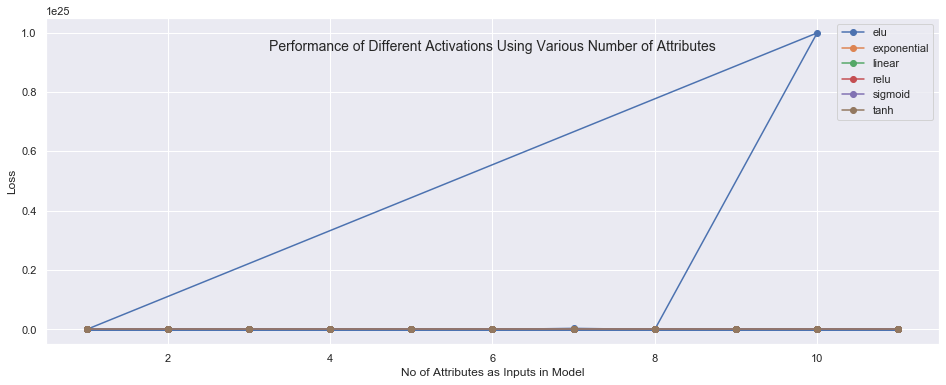

In [112]:
# Plot the actvations to see which performed best
plt.rcParams["figure.figsize"] = [16, 6]
groups = df.groupby(["activation"])

# Plot
fig, ax = plt.subplots()
ax.margins(0.05) # Optional, just adds 5% padding to the autoscaling
for activation, group in groups:
    ax.plot(group["no_attrib"], group["loss"], marker='.', linestyle='-', ms=12, label=activation)
ax.legend()
ax.set_ylabel("Loss")
ax.set_xlabel("No of Attributes as Inputs in Model")
ax.text(.5,.9,"Performance of Different Activations Using Various Number of Attributes", horizontalalignment='center',transform=ax.transAxes,fontsize=14)

Text(0.5, 0.9, 'Performance of Different Optimiser Using Various Number of Attributes')

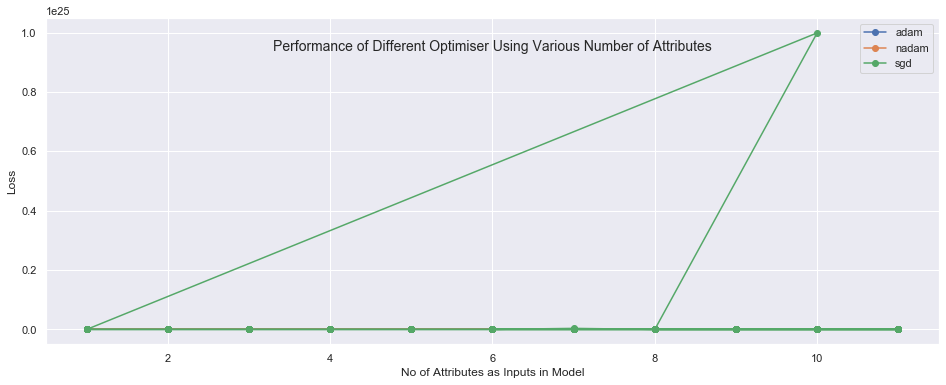

In [113]:
# Plot the actvations to see which performed best
plt.rcParams["figure.figsize"] = [16, 6]
groups = df.groupby('optimiser')

# Plot
fig, ax = plt.subplots()
ax.margins(0.05) # Optional, just adds 5% padding to the autoscaling
for optimiser, group in groups:
    ax.plot(group["no_attrib"], group["loss"], marker='.', linestyle='-', ms=12, label=optimiser)
ax.legend()
ax.set_ylabel("Loss")
ax.set_xlabel("No of Attributes as Inputs in Model")
ax.text(.5,.9,"Performance of Different Optimiser Using Various Number of Attributes", horizontalalignment='center',transform=ax.transAxes,fontsize=14)

In [114]:
# Sort the various model iterations according to loss to determine the best model(s) to chose) 
df.sort_values(by='loss', ascending=True)

,no_attrib,scaling,test_size,activation,optimiser,no_epochs,batch_size,loss
114,5,False,0.3,elu,nadam,100,10,8.043282e+00
428,11,False,0.3,sigmoid,sgd,100,10,8.382595e+00
43,11,False,0.3,exponential,adam,100,10,8.532959e+00
164,11,False,0.3,sigmoid,sgd,100,10,8.657051e+00
505,11,False,0.3,exponential,adam,100,10,8.784707e+00
581,10,False,0.3,elu,nadam,100,10,9.229037e+00
466,5,False,0.3,relu,adam,100,10,9.291601e+00
116,7,False,0.3,elu,nadam,100,10,9.375573e+00
136,5,False,0.3,relu,sgd,100,10,9.804588e+00
74,9,False,0.3,relu,nadam,100,10,9.930583e+00
